#### Housekeeping

In [7]:
# Bunch of imports 
import therpy as tp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import pandas as pd
import bec1db as bec1db_package
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings("ignore")
import scipy.special
import os.path
import pickle
import ipywidgets
from IPython.display import display

cst = tp.cst(sigmaf=0.5)
kHz = cst.h * 1e3
twopi = np.pi * 2
bec1db = bec1db_package.Tullia(delta=20)

In [2]:
def dataset_counter(df, bg_param, bg_value, x='x', plot=False, ax=None, xlabel='x'):
    '''
    count the occurances of various x data points and bg points 
    '''
    # Count number of images 
    unique_x = np.unique(df[x])
    data_counts = np.array([np.sum(df[x][df[bg_param] != bg_value] == xi) for xi in unique_x])
    bg_counts = np.array([np.sum(df[x][df[bg_param] == bg_value] == xi) for xi in unique_x])
    dataset_counter = [unique_x, data_counts, bg_counts]
    
    # Plot
    if plot: 
        ax = plt.subplots(figsize=[15,4])[1] if (ax is None) else ax
        width = np.min(np.diff(dataset_counter[0]))*0.75 if (len(dataset_counter[0]) > 1) else 1
        ax.bar(dataset_counter[0], dataset_counter[1], width, label='Data')
        ax.bar(dataset_counter[0], dataset_counter[2], width, bottom=dataset_counter[1], label='BG')
        ax.legend()
        ax.set(xlabel = xlabel, ylabel='Shots')
        plt.tight_layout()
    
    return dataset_counter

In [3]:
# Constants 
import_params = ['ExpansionTime','SideGreenEvap','WaitBox',
               'IREvap','HeatTime','ShakeWait', 'HeatCycles',
               'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
               'SeqMode']

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=800, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )

fontsize = 15

In [4]:
# Specific Functions 

def sin_decay(x, wavelength=1, kappa=0, amplitude=1, phase=0, a0=0, a1=0, a2=0):
    return amplitude * np.exp(- x * kappa) * np.sin(twopi/wavelength * x - phase) + a0 + a1*x + a2*x**2

def calculate_data_sharedBG_usingCenter(df):
    # Count number of images 
    unique_x = np.unique(df.x)
    data_counts = np.array([np.sum(df.x[df[background_parameter] != background_value].values == x) for x in unique_x])
    background_counts = np.array([np.sum(df.x[df[background_parameter] == background_value].values == x) for x in unique_x])
    dataset_counter = [unique_x, data_counts, background_counts]

    # Gather nz_raw 
    df['nz_raw'] = [im.nz for im in tqdm(df.image)]
    
    # Fitting erf to get center and box length 
    guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
    def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
        y = tp.erf(x, x1, s1) + tp.erf(-x, -x2, s2)
        return y*amp/2 + offset + slope*x
    df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

    # Get the background profile 
    bg_ind = (df[background_parameter] == background_value)
    length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
    amp = np.mean([fr[4] for fr in df.fitres_erf])
    nz_bg_all = [tp.Curve(r.nz_raw.x - (r.fitres_erf[0] + r.fitres_erf[1])/2 + length/2, 
        (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
    nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
    nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

    # Process particular x 
    def process_particular_x(x, ):
        # collect bg and data ind for this x 
        data_ind = (df[background_parameter] != background_value) & (df.x == x)

        # compute parameters 
        freq = np.unique(df.BoxShakeFreq[data_ind])[0]
        cycles = np.unique(df.ShakingCycles[data_ind])[0]

        # Get all nz
        nz_data_all = [tp.Curve(r.nz_raw.x - (r.fitres_erf[0] + r.fitres_erf[1])/2 + length/2, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]

        # Average nz 
        nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
        nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

        # compute delta rho 
        x = nz_bg.x.copy()
        delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
        delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )

        # return 
        return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
                nz_bg_all, data_ind, bg_ind, 
                length, amp, np.sum(data_ind), np.sum(bg_ind), freq, cycles)
    

    # df_data 
    df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                    'nz bg', 'nz data all', 'nz bg all', 'data_ind', 'bg_ind', 
                                    'length', 'amp', '# data', '# bg', 'freq', 'cycles'])
    for i, x in enumerate(dataset_counter[0]):
        if (dataset_counter[1][i] >= threshold_image_num):
            df_data.loc[x] = process_particular_x(x)
    
    return df_data

def calculate_data_sharedBG_usingTopEdge(df):
    # Count number of images 
    unique_x = np.unique(df.x)
    data_counts = np.array([np.sum(df.x[df[background_parameter] != background_value].values == x) for x in unique_x])
    background_counts = np.array([np.sum(df.x[df[background_parameter] == background_value].values == x) for x in unique_x])
    dataset_counter = [unique_x, data_counts, background_counts]
    
    # Gather nz_raw 
    df['nz_raw'] = [im.nz for im in tqdm(df.image)]
    
    # Fitting erf to get center and box length 
    guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
    def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
        y = tp.erf(x, x1, s1) + tp.erf(-x, -x2, s2)
        return y*amp/2 + offset + slope*x
    df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]

    # Get the background profile 
    bg_ind = (df[background_parameter] == background_value)
    length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
    amp = np.mean([fr[4] for fr in df.fitres_erf])
    nz_bg_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
        (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[bg_ind].iterrows()]
    nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
    nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

    # Process particular x 
    def process_particular_x(x, ):
        # collect bg and data ind for this x 
        data_ind = (df[background_parameter] != background_value) & (df.x == x)

        # compute parameters 
        freq = np.unique(df.BoxShakeFreq[data_ind])[0]
        cycles = np.unique(df.ShakingCycles[data_ind])[0]

        # Get all nz
        nz_data_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.fitres_erf[4]) for i, r in df[data_ind].iterrows()]

        # Average nz 
        nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
        nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])

        # compute delta rho 
        x = nz_bg.x.copy()
        delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
        delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )

        # return 
        return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
                nz_bg_all, data_ind, bg_ind, 
                length, amp, np.sum(data_ind), np.sum(bg_ind), freq, cycles)
    

    # df_data 
    df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                    'nz bg', 'nz data all', 'nz bg all', 'data_ind', 'bg_ind', 
                                    'length', 'amp', '# data', '# bg', 'freq', 'cycles'])
    for i, x in enumerate(dataset_counter[0]):
        if (dataset_counter[1][i] >= threshold_image_num):
            df_data.loc[x] = process_particular_x(x)
    
    return df_data

def calculate_shifted_app_center(df, df_data): 
    # Compute x, y origin for all images 
    def get_origin_pixel(r):
        # Get the index of the right edge of the box == this is the y origin 
        use_center = (r.fitres_erf[0] + r.fitres_erf[1])/2
        y = tp.Curve((r.nz_raw.x - use_center) * 1e6, np.arange(len(r.nz_raw.x)))(0)
        # Get the center from xsec at that y pixel 
        x = tp.Curve(np.arange(len(r.image.xsec.center)), r.image.xsec.center)(y)
        return [x, y]
    origin = np.array([get_origin_pixel(r) for i,r in df.iterrows()])
    df['origin_x'], df['origin_y'] = origin[:,0], origin[:,1]
    
    # define grid based on average origin 
    r = df.iloc[0]
    x = np.arange(r.image.app.shape[1]) - np.mean(df.origin_x)
    y = np.arange(r.image.app.shape[0]) - np.mean(df.origin_y)
    xx, yy = np.meshgrid(x, y)

    # Function to compute app_shifted 
    import scipy.interpolate
    def compute_app_shifted(r):
        x_ = np.arange(r.image.app.shape[1]) - r.origin_x
        y_ = np.arange(r.image.app.shape[0]) - r.origin_y
        interp = scipy.interpolate.interp2d(x_, y_, r.image.app, kind='linear')
        return interp(x, y)
    
    # compute shifted app for all images 
    df['app_shifted'] = [compute_app_shifted(r) for i,r in df.iterrows()]
    
    # Add shifted app to the df_data 
    df_data['2D Delta rho'] = None
    for x, r in df_data.iterrows():
        bg_mean = np.mean([a/np.mean(a) for a in df[r.bg_ind].app_shifted], axis = 0)
        data_mean = np.mean([a/np.mean(a) for a in df[r.data_ind].app_shifted], axis=0)
        df_data['2D Delta rho'].loc[x] = data_mean - bg_mean
        

def calculate_shifted_app_TopEdge(df, df_data): 
    # Compute x, y origin for all images 
    def get_origin_pixel(r):
        # Get the index of the right edge of the box == this is the y origin 
        use_center = r.fitres_erf[1]
        y = tp.Curve((r.nz_raw.x - use_center) * 1e6, np.arange(len(r.nz_raw.x)))(0)
        # Get the center from xsec at that y pixel 
        x = tp.Curve(np.arange(len(r.image.xsec.center)), r.image.xsec.center)(y)
        return [x, y]
    origin = np.array([get_origin_pixel(r) for i,r in df.iterrows()])
    df['origin_x'], df['origin_y'] = origin[:,0], origin[:,1]
    
    # define grid based on average origin 
    r = df.iloc[0]
    x = np.arange(r.image.app.shape[1]) - np.mean(df.origin_x)
    y = np.arange(r.image.app.shape[0]) - np.mean(df.origin_y)
    xx, yy = np.meshgrid(x, y)

    # Function to compute app_shifted 
    import scipy.interpolate
    def compute_app_shifted(r):
        x_ = np.arange(r.image.app.shape[1]) - r.origin_x
        y_ = np.arange(r.image.app.shape[0]) - r.origin_y
        interp = scipy.interpolate.interp2d(x_, y_, r.image.app, kind='linear')
        return interp(x, y)
    
    # compute shifted app for all images 
    df['app_shifted'] = [compute_app_shifted(r) for i,r in df.iterrows()]
    
    # Add shifted app to the df_data 
    df_data['2D Delta rho'] = None
    for x, r in df_data.iterrows():
        bg_mean = np.mean([a/np.mean(a) for a in df[r.bg_ind].app_shifted], axis = 0)
        data_mean = np.mean([a/np.mean(a) for a in df[r.data_ind].app_shifted], axis=0)
        df_data['2D Delta rho'].loc[x] = data_mean - bg_mean


In [5]:
def calculate_data_separatedBG_usingTopEdge(df):
    # Count number of images 
    unique_x = np.unique(df.x)
    data_counts = np.array([np.sum(df.x[df[background_parameter] != background_value].values == x) for x in unique_x])
    background_counts = np.array([np.sum(df.x[df[background_parameter] == background_value].values == x) for x in unique_x])
    dataset_counter = [unique_x, data_counts, background_counts]
    
    # Gather nz_raw 
    df['nz_raw'] = [im.nz for im in tqdm(df.image)]
    
    # Fitting erf to get center and box length 
    guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
    def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
        y = tp.erf(x, x1, s1) + tp.erf(-x, -x2, s2)
        return y*amp/2 + offset + slope*x
    df['fitres_erf'] = [nz.fit(fitfun_erf_2, guess)[0] for nz in df.nz_raw]
    
    # Compute integral of n(z) used for rescaling 
    df['nz_integral'] = [np.trapz(r.nz_raw.y - r.fitres_erf[5], r.nz_raw.x) for i, r in df.iterrows()]
    
    # Process particular x 
    def process_particular_x(x, ):
        # collect bg and data ind for this x 
        data_ind = (df[background_parameter] != background_value) & (df.x == x)
        bg_ind = (df[background_parameter] == background_value) & (df.x == x)
        
        # compute parameters 
        freq = np.unique(df.BoxShakeFreq[data_ind])[0]
        cycles = np.unique(df.ShakingCycles[data_ind])[0]
        length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
        amp = np.mean(df[df.x == x].nz_integral)
        
        # Get all nz
        nz_data_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.nz_integral) for i, r in df[data_ind].iterrows()]
        nz_bg_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.nz_integral) for i, r in df[bg_ind].iterrows()]
        
        # Average nz 
        nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
        nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])
        nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
        nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])
        
        # compute delta rho 
        x = nz_bg.x.copy()
        delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
        delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )

        # return 
        return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
                nz_bg_all, data_ind, bg_ind, 
                length, amp, np.sum(data_ind), np.sum(bg_ind), freq, cycles)
    
    # df_data 
    df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                    'nz bg', 'nz data all', 'nz bg all', 'data_ind', 'bg_ind', 
                                    'length', 'amp', '# data', '# bg', 'freq', 'cycles'])
    for i, x in enumerate(dataset_counter[0]):
        if (dataset_counter[1][i] >= threshold_image_num):
            df_data.loc[x] = process_particular_x(x)
    
    # Compute x, y origin for all images 
    def get_origin_pixel(r):
        # Get the index of the right edge of the box == this is the y origin 
        use_center = r.fitres_erf[1]
        y = tp.Curve((r.nz_raw.x - use_center) * 1e6, np.arange(len(r.nz_raw.x)))(0)
        # Get the center from xsec at that y pixel 
        x = tp.Curve(np.arange(len(r.image.xsec.center)), r.image.xsec.center)(y)
        return [x, y]
    origin = np.array([get_origin_pixel(r) for i,r in df.iterrows()])
    df['origin_x'], df['origin_y'] = origin[:,0], origin[:,1]
    
    # define grid based on average origin 
    r = df.iloc[0]
    x = np.arange(r.image.app.shape[1]) - np.mean(df.origin_x)
    y = np.arange(r.image.app.shape[0]) - np.mean(df.origin_y)
    xx, yy = np.meshgrid(x, y)
    
    # Function to compute app_shifted 
    import scipy.interpolate
    def compute_app_shifted(r):
        x_ = np.arange(r.image.app.shape[1]) - r.origin_x
        y_ = np.arange(r.image.app.shape[0]) - r.origin_y
        interp = scipy.interpolate.interp2d(x_, y_, r.image.app, kind='linear')
        return interp(x, y)
    
    # compute shifted app for all images 
    df['app_shifted'] = [compute_app_shifted(r) for i,r in df.iterrows()]
    
    # Add shifted app to the df_data 
    df_data['2D Delta rho'] = None
    for x, r in df_data.iterrows():
        bg_mean = np.mean([a/np.mean(a) for a in df[r.bg_ind].app_shifted], axis = 0)
        data_mean = np.mean([a/np.mean(a) for a in df[r.data_ind].app_shifted], axis=0)
        df_data['2D Delta rho'].loc[x] = data_mean - bg_mean
    
    return df_data

In [6]:
def calculate_data(df, background='same', align='top', zero='bottom'):
    '''
    background = {'same', 'diff'}
    align = What point to use for alignment {'top', 'bottom', 'center'}
    zero = Where to put zero of z {'top', 'bottom', 'center'}
    '''
    # Count number of images 
    unique_x = np.unique(df.x)
    data_counts = np.array([np.sum(df.x[df[background_parameter] != background_value].values == x) for x in unique_x])
    background_counts = np.array([np.sum(df.x[df[background_parameter] == background_value].values == x) for x in unique_x])
    dataset_counter = [unique_x, data_counts, background_counts]
    
    # Gather nz_raw 
    df['nz_raw'] = [im.nz for im in tqdm(df.image)]
    
    # Fitting erf to get center and box length 
    guess = [-50e-6, 50e-6, 5e-6, 5e-6, 0.6e18, 1e15, ]
    def fitfun_erf_2(x, x1, x2, s1, s2, amp=1, offset=0, slope=0):
        y = tp.erf(x, x1, s1) + tp.erf(-x, -x2, s2)
        return y*amp/2 + offset + slope*x
    df['fitres_erf'] = [tp.curve_fit(fitfun_erf_2, guess, *nz.data)[0] for nz in df.nz_raw]
    
    # Compute integral of n(z) used for rescaling 
    df['nz_integral'] = [np.trapz(r.nz_raw.y - r.fitres_erf[5], r.nz_raw.x) for i, r in df.iterrows()]
    
    # Initialize df_data 
    df_data = pd.DataFrame()
    for i, x in enumerate(dataset_counter[0]):
        if (dataset_counter[1][i] >= threshold_image_num):
            df_data.loc[x] = None
    
    # Process particular x 
    def process_particular_x(x, ):
        # collect bg and data ind for this x 
        data_ind = (df[background_parameter] != background_value) & (df.x == x)
        if background == 'diff': bg_ind = (df[background_parameter] == background_value) & (df.x == x)
        else: bg_ind = (df[background_parameter] == background_value)
        
        # compute parameters 
        freq = np.unique(df.BoxShakeFreq[data_ind])[0]
        cycles = np.unique(df.ShakingCycles[data_ind])[0]
        length = np.mean([fr[1] - fr[0] for fr in df.fitres_erf[bg_ind]])
        if background == 'diff': amp = np.mean(df[df.x == x].nz_integral)
        else: amp = np.mean(df.nz_integral)
        
        # Get all nz
        nz_data_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.nz_integral) for i, r in df[data_ind].iterrows()]
        nz_bg_all = [tp.Curve(r.nz_raw.x - r.fitres_erf[1] + length, 
                 (r.nz_raw.y - r.fitres_erf[5]) * amp / r.nz_integral) for i, r in df[bg_ind].iterrows()]
        
        # Average nz 
        nz_data_concat = tp.Curve(np.concatenate([nz.x for nz in nz_data_all]), np.concatenate([nz.y for nz in nz_data_all])).sortbyx()
        nz_data = nz_data_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])
        nz_bg_concat = tp.Curve(np.concatenate([nz.x for nz in nz_bg_all]), np.concatenate([nz.y for nz in nz_bg_all])).sortbyx()
        nz_bg = nz_bg_concat.binbyx(step = np.diff(df.iloc[0].nz_raw.x)[0])
        
        # compute delta rho 
        x = nz_bg.x.copy()
        delta_rho = tp.Curve(x, nz_data(x) - nz_bg(x))
        delta_rho_rho = tp.Curve(x, (nz_data(x) - nz_bg(x))/nz_bg(x) )

        # return 
        return (delta_rho, delta_rho_rho, nz_data, nz_bg, nz_data_all, 
                nz_bg_all, data_ind, bg_ind, 
                length, amp, np.sum(data_ind), np.sum(bg_ind), freq, cycles)
    
    # df_data 
    df_data = pd.DataFrame(columns=['Delta rho', 'Delta rho / rho', 'nz data', 
                                    'nz bg', 'nz data all', 'nz bg all', 'data_ind', 'bg_ind', 
                                    'length', 'amp', '# data', '# bg', 'freq', 'cycles'])
    for i, x in enumerate(dataset_counter[0]):
        if (dataset_counter[1][i] >= threshold_image_num):
            df_data.loc[x] = process_particular_x(x)
    
    # Compute x, y origin for all images 
    def get_origin_pixel(r):
        # Get the index of the right edge of the box == this is the y origin 
        use_center = r.fitres_erf[1]
        y = tp.Curve((r.nz_raw.x - use_center) * 1e6, np.arange(len(r.nz_raw.x)))(0)
        # Get the center from xsec at that y pixel 
        x = tp.Curve(np.arange(len(r.image.xsec.center)), r.image.xsec.center)(y)
        return [x, y]
    origin = np.array([get_origin_pixel(r) for i,r in df.iterrows()])
    df['origin_x'], df['origin_y'] = origin[:,0], origin[:,1]
    
    # define grid based on average origin 
    r = df.iloc[0]
    x = np.arange(r.image.app.shape[1]) - np.mean(df.origin_x)
    y = np.arange(r.image.app.shape[0]) - np.mean(df.origin_y)
    xx, yy = np.meshgrid(x, y)
    
    # Function to compute app_shifted 
    import scipy.interpolate
    def compute_app_shifted(r):
        x_ = np.arange(r.image.app.shape[1]) - r.origin_x
        y_ = np.arange(r.image.app.shape[0]) - r.origin_y
        interp = scipy.interpolate.interp2d(x_, y_, r.image.app, kind='linear')
        return interp(x, y)
    
    # compute shifted app for all images 
    df['app_shifted'] = [compute_app_shifted(r) for i,r in df.iterrows()]
    
    # Add shifted app to the df_data 
    df_data['2D Delta rho'] = None
    for x, r in df_data.iterrows():
        bg_mean = np.mean([a/np.mean(a) for a in df[r.bg_ind].app_shifted], axis = 0)
        data_mean = np.mean([a/np.mean(a) for a in df[r.data_ind].app_shifted], axis=0)
        df_data['2D Delta rho'].loc[x] = data_mean - bg_mean
    
    return df_data

# Load Data from Images 

In [5194]:
df_all = pd.DataFrame()

In [5195]:
# Relevant Parameters 
x_var_name = 'BoxShakeFreq'
x_var_label = r'$\nu$ (Hz)'
# x_var_label = 'Amplitude (V)'
background_parameter = 'ShakingCycles'
background_value = 0
threshold_image_num = 1
image_use = 'A'

In [5660]:
# Import from Clipboard 
df_all = tp.images_from_clipboard(df=df_all, x=x_var_name, params=import_params, 
                                  image_func=tp.Hybrid_Image, download=image_use, display=True)


Updating the local database...
Done

Total Number of Shots 80, Images 80


,time,image,A,B,S,download,ExpansionTime,SideGreenEvap,WaitBox,IREvap,...,ShakeWait,HeatCycles,ShakingCycles,BoxShakeFreq,BoxShakeAmp,BoxShakeTime,SeqMode,x,total_atoms,use
name,,,,,,,,,,,,,,,,,,,,,
09-15-2017_21_21_46_TopA,0.000000,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,...,0.0,500.0,0.0,100.0,0.2,0.0,None,100.0,392896,1.0
09-15-2017_21_22_41_TopA,0.916667,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,...,0.0,500.0,0.0,100.0,0.2,0.0,None,100.0,368465,1.0
09-15-2017_21_23_35_TopA,1.816667,Image object,True,False,False,True,2000.0,0.32,0.5,0.5,...,0.0,500.0,0.0,100.0,0.2,0.0,None,100.0,400542,1.0


In [5661]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1183, center_y = 1376, fudge=1.75, width=800, height=800, subsample=3, 
                  xsec_extension='poly0', xsec_slice_width=7, xsec_fit_range=1.0, radial_selection=0.9,)}

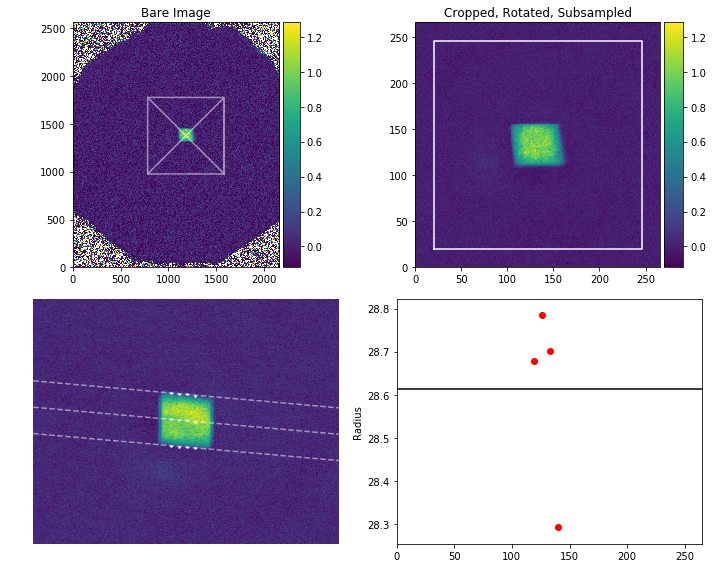

In [5662]:
# Verify Settings 

# Apply to all Images 
for n,r in df_all.iterrows(): r.image.set(**settings)
    
# Function to plot the restults 
def temp(test=np.random.randint(0, df_all.shape[0])):
    r = df_all.iloc[test]
    ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8])[1].flatten()
    r.image.plot_crop(ax=ax[0:2])
    r.image.xsec.infoplot(axs=ax[2:4])
    plt.tight_layout()
    plt.show()

if df_all.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_all.shape[0]-1))


Total Images 80 ==> Good 74, Bad 6


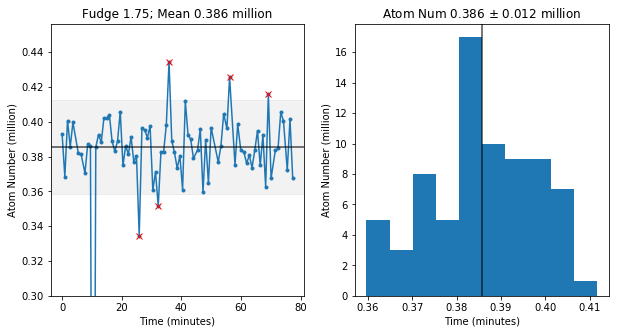

In [5663]:
# Atom Number Filter 
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image)]
ax = tp.atom_num_filter(df=df_all, keep=0.07, offset=0.0, display=True, plot=True)
ax[0].set(ylim=[0.30,None])
df = df_all[df_all.use]

[  70.   80.   90.  100.  104.  107.  110.  113.  116.  120.  130.  140.
  150.  160.  170.  180.  190.  200.  210.  220.  230.  240.  250.  260.
  270.  280.  290.  300.  310.  320.  330.  340.  350.  360.  370.  380.
  390.  400.  410.  420.  430.  440.  450.  460.  470.  480.  490.  500.
  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.  740.
  760.  780.  800.]


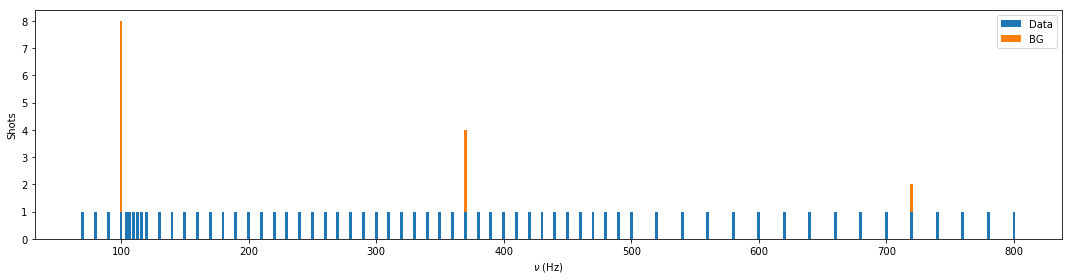

In [5664]:
# Dataset Explorer 
ds_counter = dataset_counter(df=df, bg_param=background_parameter, bg_value=background_value, plot=True, xlabel=x_var_label)
print(np.unique(df.x.values))

In [5665]:
# Compute df_data and dict_data 
# df_data = calculate_data_sharedBG_usingTopEdge(df)
# calculate_shifted_app_TopEdge(df, df_data)

df_data = calculate_data_sharedBG_usingCenter(df)
calculate_shifted_app_center(df, df_data)

# df_data = calculate_data_separatedBG_usingTopEdge(df)


dict_data = dict()


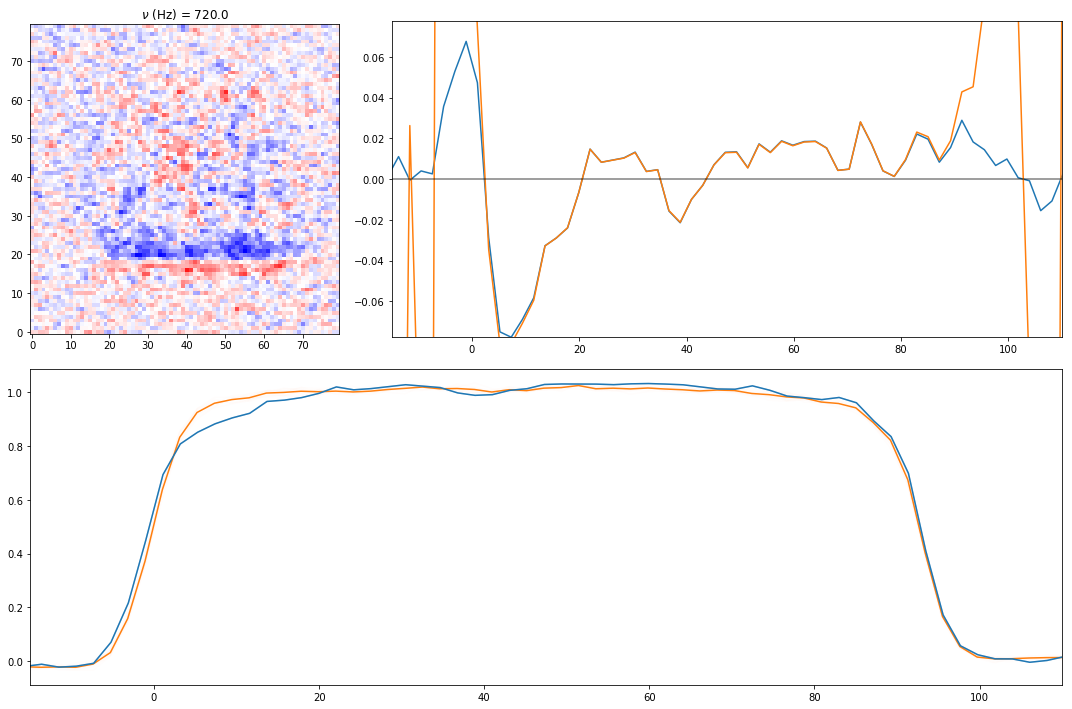

In [5666]:
# Plot 2D Images and integrated profiles 
plot_xlim = [-15, 110]
def temp(test=np.random.randint(0, df_data.shape[0])):
    r = df_data.iloc[test]
    app = r['2D Delta rho']
    roi = tp.get_roi(app, width=80, height=80)
    clim = np.max(np.abs(app[roi])) * 1.0
    clim = [-clim, clim]
    fig = plt.figure(figsize=[15, 10])
    # Plot Image
    plt.subplot2grid((2,3),(0,0))
    plt.imshow(app[roi], origin=0, clim=clim, cmap='bwr')
    plt.title("{} = {}".format(x_var_label, r.name))
    # Plot Average delta rho 
    plt.subplot2grid((2,3),(0,1),colspan=2 )
    c = tp.Curve(r['Delta rho'].x * 1e6, r['Delta rho'].y / r.amp)
    ymax = np.max(np.abs(c.y))
    plt.plot(*c.data)
    c = tp.Curve(r['Delta rho / rho'].x * 1e6, r['Delta rho / rho'].y)
    plt.plot(*c.data)
    plt.ylim([-ymax, ymax])
    plt.axhline(0, c='k', alpha=0.5)
    plt.xlim(plot_xlim)
    # Plot All BG and Data nz 
    plt.subplot2grid((2,1),(1,0))
    for n in r['nz bg all']:
        plt.plot(n.x*1e6, n.y/r.amp, 'C1-', alpha=0.01)
    plt.plot(r['nz bg'].x*1e6, r['nz bg'].y / r.amp, 'C1-')
    for n in r['nz data all']:
        plt.plot(n.x*1e6, n.y/r.amp, 'C0-', alpha=0.2)
    plt.plot(r['nz data'].x*1e6, r['nz data'].y / r.amp, 'C0-')
    plt.xlim(plot_xlim)
    plt.tight_layout()
    plt.show()

if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

# Single Sided Decay Fits

In [4054]:
# Cycle Selector 
_speed = 20e-3
_length = 80e-6
_freq = np.arange(450, 1300, 100)
_cycles = _length / _speed * _freq
for f,c in zip(_freq, _cycles): print('{} -- {:.2f}'.format(f, c))

450 -- 1.80
550 -- 2.20
650 -- 2.60
750 -- 3.00
850 -- 3.40
950 -- 3.80
1050 -- 4.20
1150 -- 4.60
1250 -- 5.00


In [3282]:
# Reduced Plots and Info for Faster Processing 
savefig = ipywidgets.Checkbox(value=False, description='Save Fig')
display(savefig)
folder_name = df.iloc[0].name[0:14] + 'OneSidedDecay'
suffix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
suffix

'09-15-2017_14_OneSidedDecay\\'

In [3283]:
# Dataset Info 
speed_sound_guess = 23 * 1e-3
fit_lims = np.array([10, 75])
plot_lims = np.array([-10, 100])

In [3284]:
# Prepare for fit 
df_data['fitres'] = None
df_data['fit_guess'] = [dict(wavelength = [speed_sound_guess / r.freq * 1e6, r'$\mu m$'], 
                             kappa = [0.05, r'1/$\mu m$'], 
                             amplitude = [5, '%'], phase = [0, 'rad'], a0=1e-1, a1=1e-2) for n,r in df_data.iterrows()]
df_data['fit_fixed'] = [dict() for n,r in df_data.iterrows()]

# Override guess for specific dataset 
# df_data.loc[600, 'fit_guess']['a0'] = 0.1

# Remove some data points 
df_data['use'] = True
# df_data.loc[900, 'use'] = True

             FitValue  FitError      Units  Guess  LowerBound  UpperBound  FitError%
wavelength  32.873482  0.793180    $\mu m$  46.00        -inf         inf   2.412827
kappa        0.014343  0.004197  1/$\mu m$   0.05        -inf         inf  29.262094
amplitude   -5.556290  0.855078          %   5.00        -inf         inf  15.389375
phase        0.984638  0.188573        rad   0.00        -inf         inf  19.151529
a0          -1.504537  0.464257       None   0.10        -inf         inf  30.857114
a1           0.046954  0.009526       None   0.01        -inf         inf  20.287739
a2           0.000000  0.000000        NaN   0.00    0.000000    0.000000   0.000000


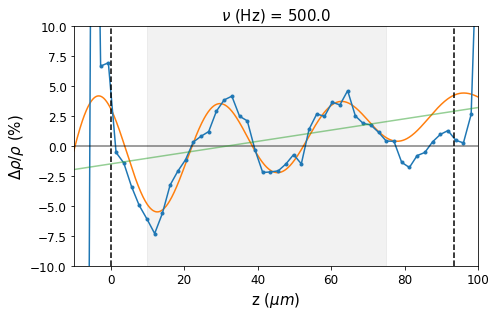

In [3285]:
# Fit and Plot Tests 
use = 'Delta rho / rho'
def temp(test=np.random.randint(0, df_data.shape[0]), plot=True, amp=0.0):
    r = df_data.iloc[test]
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    xp = np.linspace(plot_lims[0], plot_lims[1], 1000)
    cf = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=fit_lims).data, plot=False, info=True, fixed=r.fit_fixed)
    df_data.loc[r.name, 'fitres'] = cf
    if plot:
        fig = plt.figure(figsize=[7, 4.5])
        plt.plot(xp, cf(xp), 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(r.length*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, cf(c.x, amplitude=0), 'C2-', alpha=0.5)
        amp_ = abs(cf['amplitude']) * 1.5
        amp_ += abs(cf(np.array([0]), phase=np.pi/2)[0])
        if amp_ >= 10: amp_ = 9.99
        if amp == 0.0: amp = amp_
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.xlabel(r'z ($\mu m$)', fontsize=15)
        plt.ylabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("{} = {}".format(x_var_label, r.name), fontsize=15)
        plt.tight_layout()
        plt.show()
        if savefig.value: fig.savefig(suffix + 'SampleFits-{}.pdf'.format(r.name))
if df_data.shape[0] == 1: temp(0, True, 0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1), amp=(0, 20, 1))

CAN'T FIT, Returning Original Guess: Details of Error :: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
CAN'T FIT, Returning Original Guess: Details of Error :: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.


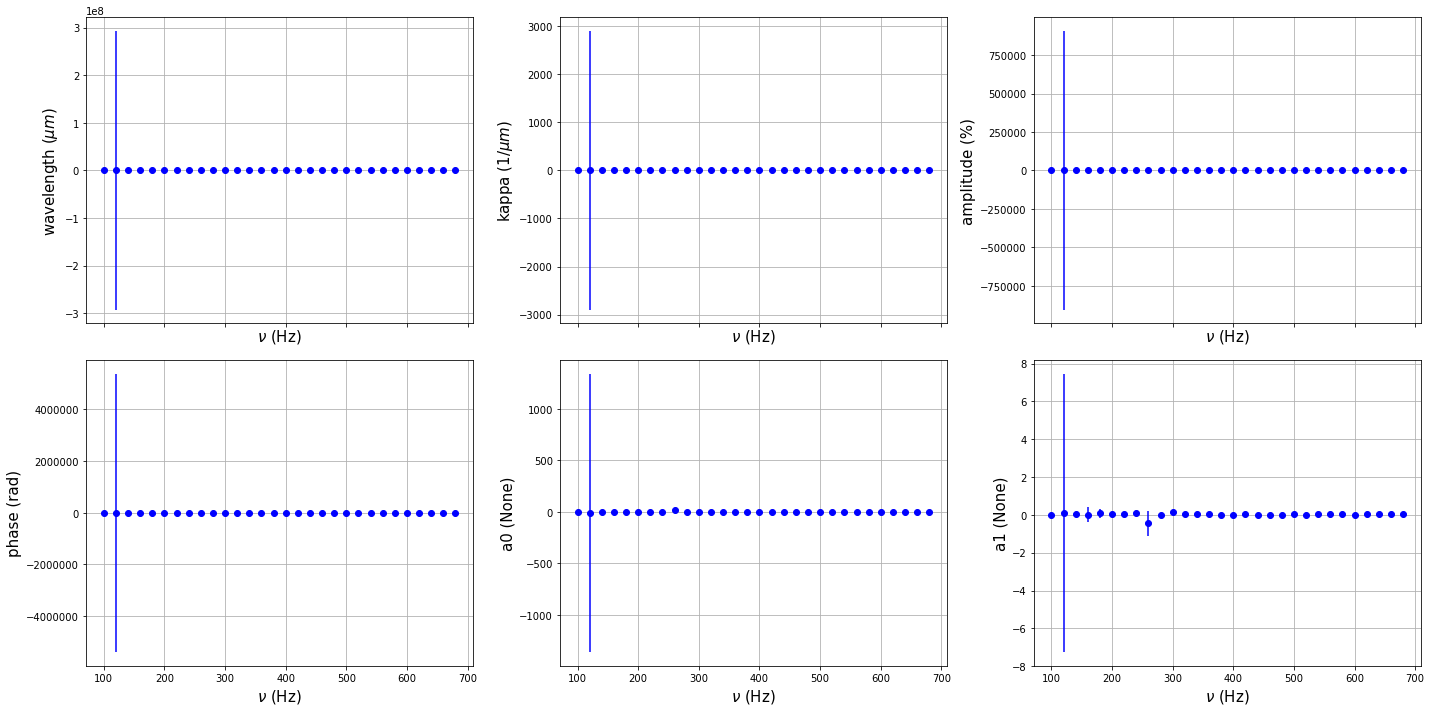

In [3286]:
# Fit all and raw plot 
for n,r in df_data.iterrows():
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    df_data.loc[r.name, 'fitres'] = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=fit_lims).data, fixed=r.fit_fixed)

# Fix phase and amp 
for n,r in df_data.iterrows():
    if r.fitres['amplitude'] < 0:
        r.fitres.fr.loc['amplitude','FitValue'] = - r.fitres['amplitude']
        r.fitres.fr.loc['phase','FitValue'] = r.fitres['phase'] + np.pi
    r.fitres.fr.loc['phase','FitValue'] = np.mod(r.fitres.fr.loc['phase','FitValue'], twopi)

# Plot 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[20,10], sharex=True)
fn_ = df_data.iloc[0].fitres.fr.index.values
fu_ = df_data.iloc[0].fitres.fr['Units'].values
ax = ax.flatten()
for i in range(6):
    ax[i].errorbar(df_data[df_data.use].index.values, [fr.fv[i] for fr in df_data[df_data.use].fitres], [fr.fe[i] for fr in df_data[df_data.use].fitres], fmt='bo')
    ax[i].errorbar(df_data[~df_data.use].index.values, [fr.fv[i] for fr in df_data[~df_data.use].fitres], [fr.fe[i] for fr in df_data[~df_data.use].fitres], fmt='ro')
    ax[i].set_ylabel("{} ({})".format(fn_[i], fu_[i]), fontsize=15)
    ax[i].set_xlabel(x_var_label, fontsize=15)
    ax[i].grid()
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'RawFits-v1.pdf')

## vs $\omega$

### Speed of Sound

In [3287]:
# Extract Dispersion Relation 
disprel = pd.DataFrame()
disprel['freq (Hz)'] = df_data[df_data.use].freq.values
disprel['wavelength (m)'] = np.array([r.fitres['wavelength'] * 1e-6 for n,r in df_data[df_data.use].iterrows()])
disprel['wavelength error'] = np.array([r.fitres.fe['wavelength'] * 1e-6 for n,r in df_data[df_data.use].iterrows()])
disprel['speed (m/s)'] = disprel['wavelength (m)'] * disprel['freq (Hz)'] 
disprel['speed error'] = disprel['wavelength error'] * disprel['freq (Hz)'] 
disprel['omega (1/s)'] = twopi * disprel['freq (Hz)'] 
disprel['k (1/m)'] = twopi / disprel['wavelength (m)'] 
disprel['k error'] = disprel['wavelength error'] * twopi / disprel['wavelength (m)']**2 

dict_data['disprel'] = disprel
disprel

,freq (Hz),wavelength (m),wavelength error,speed (m/s),speed error,omega (1/s),k (1/m),k error
0,100.0,0.000230,NaN,0.023000,NaN,628.318531,27318.196988,NaN
1,120.0,0.011734,2.922042e+02,1.408077,35064.508898,753.982237,535.469627,1.333449e+07
2,140.0,0.000061,2.008343e-05,0.008511,0.002812,879.645943,103350.714395,3.414168e+04
3,160.0,0.000089,2.510558e-05,0.014299,0.004017,1005.309649,70305.872406,1.975030e+04
4,180.0,0.000104,4.286823e-05,0.018793,0.007716,1130.973355,60179.708384,2.470904e+04
5,200.0,0.000038,2.107130e-06,0.007685,0.000421,1256.637061,163520.889958,8.967220e+03
6,220.0,0.000055,1.537744e-05,0.012008,0.003383,1382.300768,115112.614804,3.243022e+04
7,240.0,0.000058,8.777905e-06,0.013869,0.002107,1507.964474,108726.676779,1.651518e+04
8,260.0,-0.000105,5.025678e-05,-0.027229,0.013067,1633.628180,-59996.511269,2.879166e+04
9,280.0,0.000082,NaN,0.023000,NaN,1759.291886,76490.951566,NaN


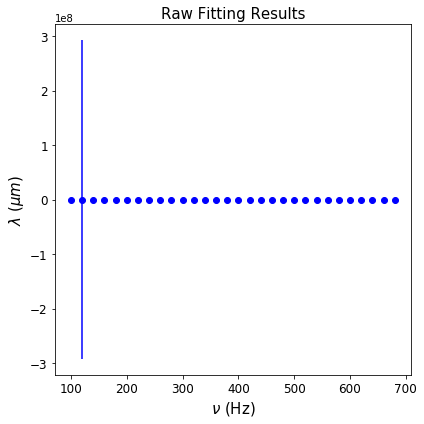

In [3288]:
# Plot Raw Fitting Results 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(disprel['freq (Hz)'], disprel['wavelength (m)']*1e6, yerr=disprel['wavelength error']*1e6, fmt='bo', )
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\lambda$ ($\mu m$)', fontsize=15)
plt.title(r'Raw Fitting Results', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

        FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
c       0.015577  0.001087  None    1.0        -inf         inf   6.981581
offset  0.000000  0.000000   NaN    0.0    0.000000    0.000000   0.000000


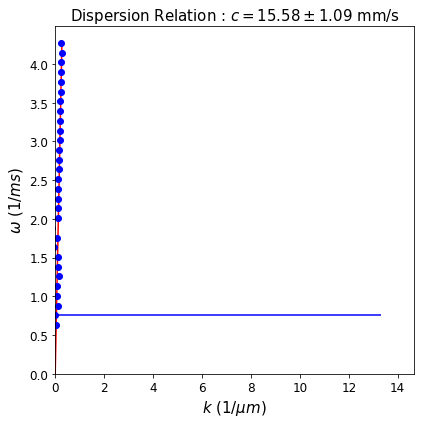

In [3289]:
# Plot omega vs k 
# line fit 
dispersion_fit = tp.curve_fit(lambda x, c=1, offset=0: offset + c*x, [1,], disprel['k (1/m)'], disprel['omega (1/s)'], plot=False, info=True)
c = dispersion_fit['c'] * 1e3
c_error = dispersion_fit.fe['c'] * 1e3
dict_data['dispersion_fit'] = dispersion_fit

fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(disprel['k (1/m)']*1e-6, disprel['omega (1/s)']*1e-3, xerr=disprel['k error']*1e-6, fmt='bo', )
xp = np.linspace(0, np.max(disprel['k (1/m)']*1e-6)*1.05)
plt.plot(xp, c*xp, 'r')
plt.xlabel(r'$k$ ($1/\mu m$)', fontsize=15)
plt.ylabel(r'$\omega$ ($1/ms$)', fontsize=15)
plt.title(r'Dispersion Relation : $c = {:.2f} \pm {:.2f}$ mm/s'.format(c, c_error), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,None])
plt.ylim([0,None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'DispersionRelation-v1.pdf')

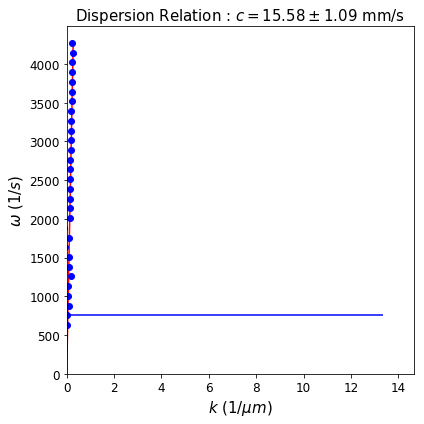

In [3290]:
# Plot omega vs k 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(disprel['k (1/m)']*1e-6, disprel['omega (1/s)'], xerr=disprel['k error']*1e-6, fmt='bo', )
xp = np.linspace(0, np.max(disprel['k (1/m)']*1e-6)*1.05)
plt.plot(xp, c*xp * 1e3, 'r')
plt.xlabel(r'$k$ ($1/\mu m$)', fontsize=15)
plt.ylabel(r'$\omega$ ($1/s$)', fontsize=15)
plt.title(r'Dispersion Relation : $c = {:.2f} \pm {:.2f}$ mm/s'.format(c, c_error), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,None])
plt.ylim([0,None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'DispersionRelation-v2.pdf')

In [3291]:
# Save Data to Excel 
if savefig.value: disprel.to_excel(suffix + 'DispersionRelation-Data.xlsx')

### Decay Rate $\Gamma$

In [3292]:
# Decay Rate Extraction 
decay = disprel.copy()
decay['kappa (1/m)'] = np.array([r.fitres['kappa'] * 1e6 for n,r in df_data[df_data.use].iterrows()])
decay['kappa error'] = np.array([r.fitres.fe['kappa'] * 1e6 for n,r in df_data[df_data.use].iterrows()])
decay['gamma (1/s)'] = 2 * decay['kappa (1/m)'] * decay['speed (m/s)'] 
decay['gamma error'] = 2 * np.sqrt((decay['speed error'] * decay['kappa (1/m)'])**2 + (decay['speed (m/s)'] * decay['kappa error'])**2)
decay['amplitude (%)'] = np.array([r.fitres.fv['amplitude'] for n,r in df_data[df_data.use].iterrows()])
dict_data['decay'] = decay
decay.head(3)

,freq (Hz),wavelength (m),wavelength error,speed (m/s),speed error,omega (1/s),k (1/m),k error,kappa (1/m),kappa error,gamma (1/s),gamma error,amplitude (%)
0,100.0,0.000230,NaN,0.023000,NaN,628.318531,27318.196988,NaN,50000.000000,NaN,2300.000000,NaN,5.000000
1,120.0,0.011734,292.204241,1.408077,35064.508898,753.982237,535.469627,1.333449e+07,28182.956792,2.893997e+09,79367.522415,8.386168e+09,10.998324
2,140.0,0.000061,0.000020,0.008511,0.002812,879.645943,103350.714395,3.414168e+04,24239.904024,5.851909e+04,412.624787,1.005427e+03,2.377081


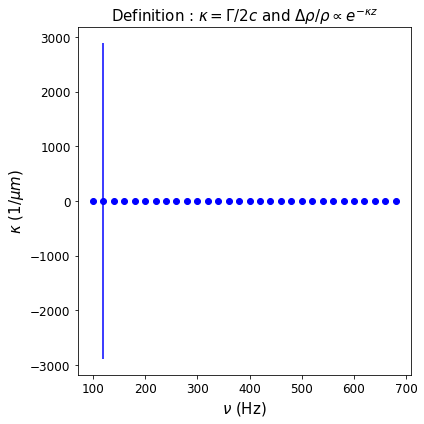

In [3293]:
# Plot Raw Fitting Results 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(decay['freq (Hz)'], decay['kappa (1/m)']*1e-6, yerr=decay['kappa error']*1e-6, fmt='bo', )
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\kappa$ ($1/\mu m$)', fontsize=15)
plt.title(r'Definition : $\kappa = \Gamma / 2c$ and $\Delta\rho/\rho \propto e^{-\kappa z}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

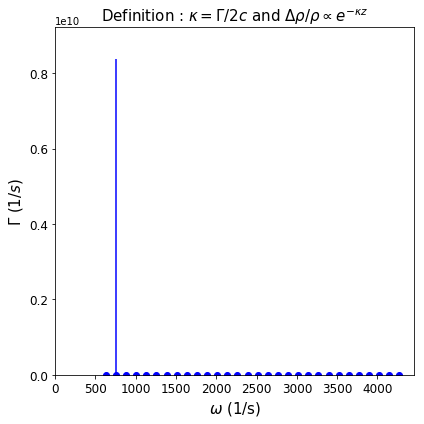

In [3294]:
# Plot Raw Fitting Results 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(decay['omega (1/s)'], decay['gamma (1/s)'], yerr=decay['gamma error'], fmt='bo', )
plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
plt.ylabel(r'$\Gamma$ ($1/s$)', fontsize=15)
plt.title(r'Definition : $\kappa = \Gamma / 2c$ and $\Delta\rho/\rho \propto e^{-\kappa z}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'GammaVsOmega-v1.pdf')

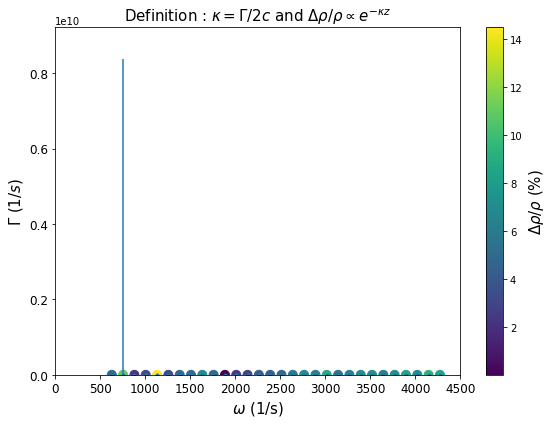

In [3295]:
# Plot Raw Fitting Results 
fig, ax = plt.subplots(figsize=[8,6])
plt.errorbar(decay['omega (1/s)'], decay['gamma (1/s)'], yerr=decay['gamma error'], fmt='.', )
plt.scatter(decay['omega (1/s)'], decay['gamma (1/s)'], c=decay['amplitude (%)'], cmap='viridis', s=80)
clb = plt.colorbar()
clb.set_label(r'$\Delta \rho / \rho$ (%)', fontsize=15)
plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
plt.ylabel(r'$\Gamma$ ($1/s$)', fontsize=15)
plt.title(r'Definition : $\kappa = \Gamma / 2c$ and $\Delta\rho/\rho \propto e^{-\kappa z}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'GammaVsOmega-v2.pdf')

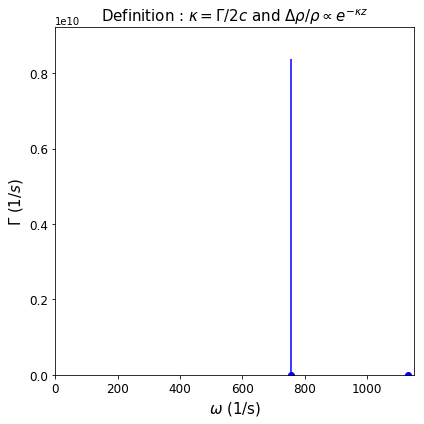

In [3296]:
# Plot Raw Fitting Results 
amp_lims = [10, 15]
decay_ = decay[(decay['amplitude (%)'] >= amp_lims[0]) & (decay['amplitude (%)'] <= amp_lims[1])]
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(decay_['omega (1/s)'], decay_['gamma (1/s)'], yerr=decay_['gamma error'], fmt='bo', )
plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
plt.ylabel(r'$\Gamma$ ($1/s$)', fontsize=15)
plt.title(r'Definition : $\kappa = \Gamma / 2c$ and $\Delta\rho/\rho \propto e^{-\kappa z}$', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'GammaVsOmega-AmpSelection.pdf')

In [3297]:
# Save Data to Excel 
if savefig.value: decay.to_excel(suffix + 'GammaVsOmega-Data.xlsx')

### Decay Rate $\Gamma$ -- Overridden $c$

              FitValue   FitError      Units    Guess  LowerBound  UpperBound    FitError%
wavelength  175.000000   0.000000        NaN  175.000  175.000000  175.000000     0.000000
kappa         0.040517   0.994898  1/$\mu m$    0.050        -inf         inf  2455.526691
amplitude     5.295802  81.876642          %    5.000        -inf         inf  1546.066767
phase        -1.465322  47.159654        rad    0.000        -inf         inf  3218.381504
a0           -3.343455  68.224327       None    0.100        -inf         inf  2040.533574
a1            0.058054   0.655727       None    0.001        -inf         inf  1129.503079
a2            0.000000   0.000000        NaN    0.000    0.000000    0.000000     0.000000


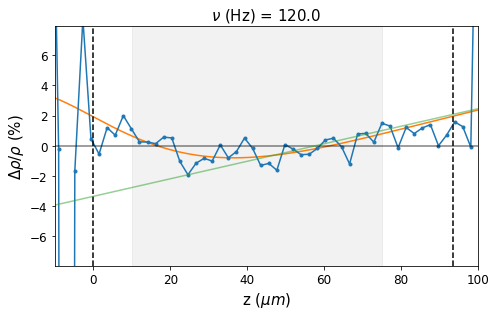

In [3298]:
# Fit and Plot Tests 
use = 'Delta rho / rho'
speed_sound = dict_data['dispersion_fit']['c']
speed_sound = 21e-3
def temp(test=np.random.randint(0, df_data.shape[0]), plot=True):
    r = df_data.iloc[test]
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    xp = np.linspace(plot_lims[0], plot_lims[1], 1000)
    guess = r.fit_guess.copy()
    del guess['wavelength']
    guess['a1'] = 1e-3
    fixed = r.fit_fixed
    fixed['wavelength'] = speed_sound / r.freq * 1e6
    cf = tp.curve_fit(sin_decay, guess, *c.trim(xlim=fit_lims).data, plot=False, info=True, fixed=fixed)
    if plot:
        fig = plt.figure(figsize=[7, 4.5])
        plt.plot(xp, cf(xp), 'C1')
        plt.plot(*c.plotdata, '.-C0')
        plt.axvline(0, c='k', linestyle='--', )
        plt.axvline(r.length*1e6, c='k', linestyle='--', )
        plt.axhline(0, c='k', linestyle='-', alpha=0.5)
        plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
        plt.plot(c.x, cf(c.x, amplitude=0), 'C2-', alpha=0.5)
        amp = abs(cf['amplitude']) * 1.5
        if amp >= 10: amp = 9.99
        plt.ylim([-amp, amp])
        plt.xlim(plot_lims)
        plt.xlabel(r'z ($\mu m$)', fontsize=15)
        plt.ylabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title("{} = {}".format(x_var_label, r.name), fontsize=15)
        plt.tight_layout()
        plt.show()
if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

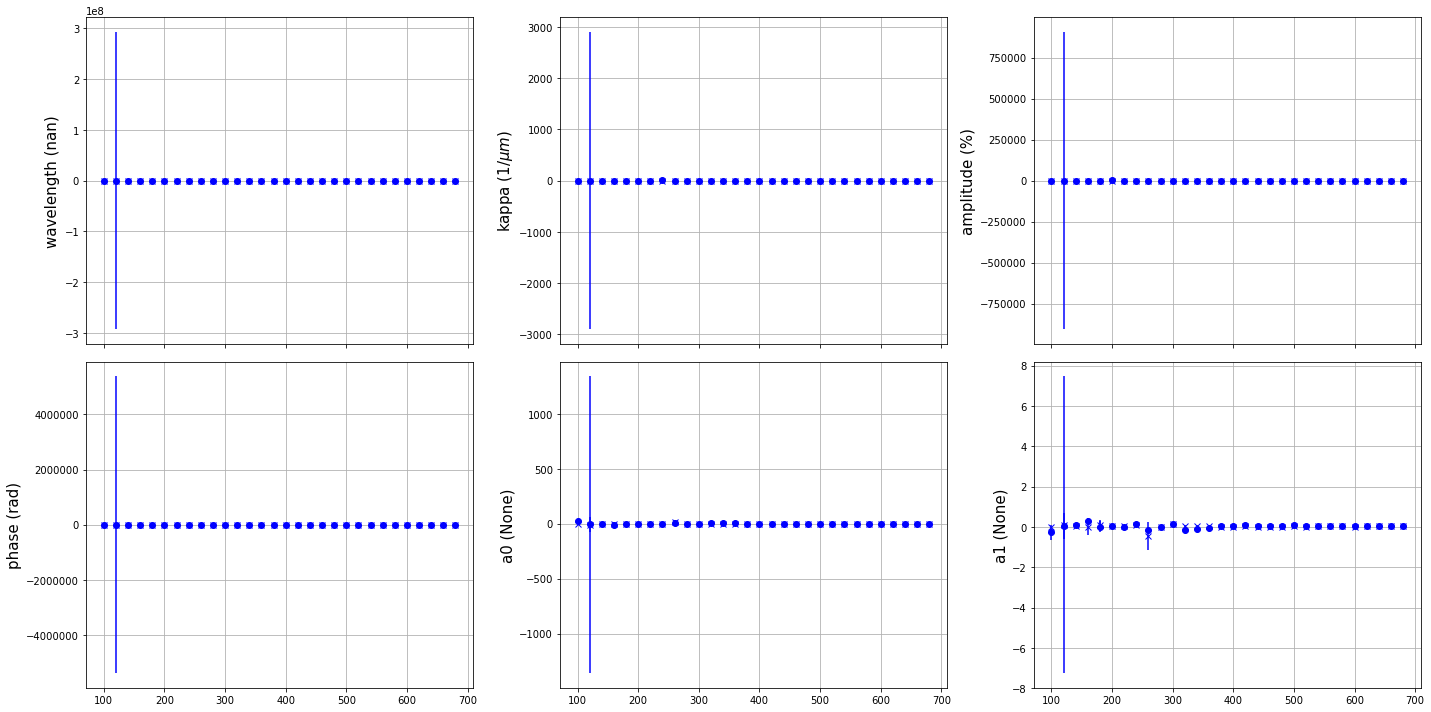

In [3299]:
# Fit with overriden 
df_data['fitres_c'] = None

# Fit all and draw plot 
for n,r in df_data.iterrows():
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    guess = r.fit_guess.copy()
    del guess['wavelength']
    fixed = r.fit_fixed
    fixed['wavelength'] = speed_sound / r.freq * 1e6
    df_data.loc[r.name, 'fitres_c'] = tp.curve_fit(sin_decay, guess, *c.trim(xlim=fit_lims).data, fixed=fixed)

# Fix phase and amp 
for n,r in df_data.iterrows():
    if r.fitres_c['amplitude'] < 0:
        r.fitres_c.fr.loc['amplitude','FitValue'] = - r.fitres_c['amplitude']
        r.fitres_c.fr.loc['phase','FitValue'] = r.fitres_c['phase'] + np.pi
    r.fitres_c.fr.loc['phase','FitValue'] = np.mod(r.fitres_c.fr.loc['phase','FitValue'], twopi)

# Plot 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[20,10], sharex=True)
fn_ = df_data.iloc[0].fitres_c.fr.index.values
fu_ = df_data.iloc[0].fitres_c.fr['Units'].values
ax = ax.flatten()
for i in range(6):
    ax[i].errorbar(df_data[df_data.use].index.values, [fr.fv[i] for fr in df_data[df_data.use].fitres_c], [fr.fe[i] for fr in df_data[df_data.use].fitres_c], fmt='bo')
    ax[i].errorbar(df_data[~df_data.use].index.values, [fr.fv[i] for fr in df_data[~df_data.use].fitres_c], [fr.fe[i] for fr in df_data[~df_data.use].fitres_c], fmt='ro')
    ax[i].errorbar(df_data[df_data.use].index.values, [fr.fv[i] for fr in df_data[df_data.use].fitres], [fr.fe[i] for fr in df_data[df_data.use].fitres], fmt='bx')
    ax[i].errorbar(df_data[~df_data.use].index.values, [fr.fv[i] for fr in df_data[~df_data.use].fitres], [fr.fe[i] for fr in df_data[~df_data.use].fitres], fmt='rx')
    ax[i].set_ylabel("{} ({})".format(fn_[i], fu_[i]), fontsize=15)
    ax[i].grid()
plt.tight_layout()
if savefig.value: fig.savefig(suffix + 'RawFits-FixedC-v1.pdf')

In [3300]:
# Decay Rate Extraction 
decay_c = pd.DataFrame()
decay_c['freq (Hz)'] = df_data[df_data.use].freq.values
decay_c['wavelength (m)'] = np.array([r.fitres_c['wavelength'] * 1e-6 for n,r in df_data[df_data.use].iterrows()])
decay_c['wavelength error'] = np.array([r.fitres_c.fe['wavelength'] * 1e-6 for n,r in df_data[df_data.use].iterrows()])
decay_c['speed (m/s)'] = decay_c['wavelength (m)'] * decay_c['freq (Hz)'] 
decay_c['speed error'] = decay_c['wavelength error'] * decay_c['freq (Hz)'] 
decay_c['omega (1/s)'] = twopi * decay_c['freq (Hz)'] 
decay_c['k (1/m)'] = twopi / decay_c['wavelength (m)'] 
decay_c['k error'] = decay_c['wavelength error'] * twopi / decay_c['wavelength (m)']**2 
decay_c['kappa (1/m)'] = np.array([r.fitres_c['kappa'] * 1e6 for n,r in df_data[df_data.use].iterrows()])
decay_c['kappa error'] = np.array([r.fitres_c.fe['kappa'] * 1e6 for n,r in df_data[df_data.use].iterrows()])
decay_c['gamma (1/s)'] = 2 * decay_c['kappa (1/m)'] * decay_c['speed (m/s)'] 
decay_c['gamma error'] = 2 * np.sqrt((decay_c['speed error'] * decay_c['kappa (1/m)'])**2 + (decay_c['speed (m/s)'] * decay_c['kappa error'])**2)
decay_c['amplitude (%)'] = np.array([r.fitres_c.fv['amplitude'] for n,r in df_data[df_data.use].iterrows()])
dict_data['decay_c'] = decay_c
decay_c

,freq (Hz),wavelength (m),wavelength error,speed (m/s),speed error,omega (1/s),k (1/m),k error,kappa (1/m),kappa error,gamma (1/s),gamma error,amplitude (%)
0,100.0,0.000210,0.0,0.021,0.0,628.318531,29919.930034,0.0,1.840907e+04,3.988237e+04,773.180977,1.675060e+03,22.408378
1,120.0,0.000175,0.0,0.021,0.0,753.982237,35903.916041,0.0,4.047710e+04,9.929534e+05,1700.038313,4.170404e+04,5.293147
2,140.0,0.000150,0.0,0.021,0.0,879.645943,41887.902048,0.0,1.262879e+05,8.125669e+04,5304.091850,3.412781e+03,53.602337
3,160.0,0.000131,0.0,0.021,0.0,1005.309649,47871.888055,0.0,2.509001e+04,2.878956e+04,1053.780430,1.209161e+03,20.850032
4,180.0,0.000117,0.0,0.021,0.0,1130.973355,53855.874062,0.0,2.912133e+04,6.003539e+04,1223.095832,2.521487e+03,11.136460
5,200.0,0.000105,0.0,0.021,0.0,1256.637061,59839.860068,0.0,2.888890e+05,1.044577e+05,12133.337096,4.387224e+03,1024.045821
6,220.0,0.000095,0.0,0.021,0.0,1382.300768,65823.846075,0.0,5.799951e+04,1.821177e+04,2435.979309,7.648943e+02,16.674333
7,240.0,0.000087,0.0,0.021,0.0,1507.964474,71807.832082,0.0,2.734635e+06,inf,114854.688567,inf,7.341134
8,260.0,0.000081,0.0,0.021,0.0,1633.628180,77791.818089,0.0,-1.474046e+04,5.169253e+03,-619.099439,2.171086e+02,4.544588
9,280.0,0.000075,0.0,0.021,0.0,1759.291886,83775.804096,0.0,1.780684e+04,1.782703e+04,747.887452,7.487352e+02,4.457055


In [3301]:
# Save Data to Excel 
if savefig.value: decay_c.to_excel(suffix + 'GammaVsOmega-FixedC-Data.xlsx')

### Next

## vs Amplitude

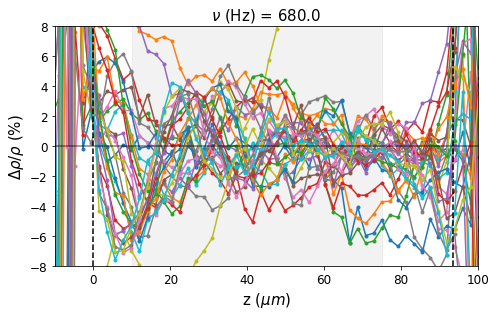

In [3302]:
# Plot all curves on top of eachother 
plot_x = df_data.index.values
amp = 8

fig = plt.figure(figsize=[7, 4.5])

for xi in plot_x:
    r = df_data.loc[xi]
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    plt.plot(c.x, c.y - r.fitres(c.x, amplitude=0), '.-')

plt.axvline(0, c='k', linestyle='--', )
plt.axvline(r.length*1e6, c='k', linestyle='--', )
plt.axhline(0, c='k', linestyle='-', alpha=0.5)
plt.axvspan(*fit_lims, alpha=0.05, color='k', label='Fourier Width')
plt.ylim([-amp, amp])
plt.xlim(plot_lims)
plt.xlabel(r'z ($\mu m$)', fontsize=15)
plt.ylabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("{} = {}".format(x_var_label, r.name), fontsize=15)
plt.tight_layout()
plt.show()
if savefig.value: plt.savefig(suffix + 'SoundWave_DiffAmplitudes_v1.pdf')

# Sonogram

In [5667]:
# Saving Figures 
savefig = ipywidgets.Checkbox(value=False, description='Save Fig')
display(savefig)
folder_name = df.iloc[0].name[0:14] + 'Sonogram'
suffix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
suffix

'09-15-2017_21_Sonogram\\'

## 2D Movies

In [5684]:
# Compute movies 
z_lims = np.array([-10, 105]) * 1e-6
use = 'Delta rho'
movie = np.array([nz.trim(xlim=z_lims).y for nz in df_data[use]]).T / np.mean(df_data.amp)
movie = [df_data.index.values, df_data[use].iloc[0].trim(xlim=z_lims).x*1e6, movie]

In [5685]:
# Compute FT 
L = np.mean(df_data.length) * 1e6
kscale = np.pi/L
k = np.arange(0, 15 * kscale, 1 * kscale)
x_keep = (movie[1] >= 0) & (movie[1] <= L)
ft = np.array([tp.fourier_transform(movie[1][x_keep], movie[2][x_keep, i], k)[1] for i in range(movie[0].size)]).T
ft_real = [movie[0], k/kscale, np.real(ft)]
ft_imag = [movie[0], k/kscale, np.imag(ft)]
ft_abs = [movie[0], k/kscale, np.abs(ft)]

In [5686]:
# Plot Prep 
clim_movie = np.max(np.abs(movie[2])) * 1
clim_ft = np.max(np.abs(ft_abs[2])) * 1

In [5687]:
# # Plot 
# fig, ax = plt.subplots(nrows=2, figsize=[18, 10], sharex=True)
# plt.sca(ax[0])
# plt.pcolor(*movie, cmap='gray', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
# plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
# plt.title(r'L = {:.2f} $\mu m$'.format(L), fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# cbr = plt.colorbar()
# cbr.set_label(label=r'$\Delta \rho / \rho$', fontsize=15)
# plt.sca(ax[1])
# plt.pcolor(*ft_real, cmap='gray', linewidth=0, vmax=clim_ft)
# plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
# plt.ylabel(r'$k$ ($\pi$/L)', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# cbr = plt.colorbar()
# cbr.set_label(label='Fourier Amplitude (arb.)', fontsize=15)
# fig.tight_layout()
# if savefig.value: fig.savefig(suffix + 'DensityAndFT_IntegersOnly_RealPart_v1.pdf')

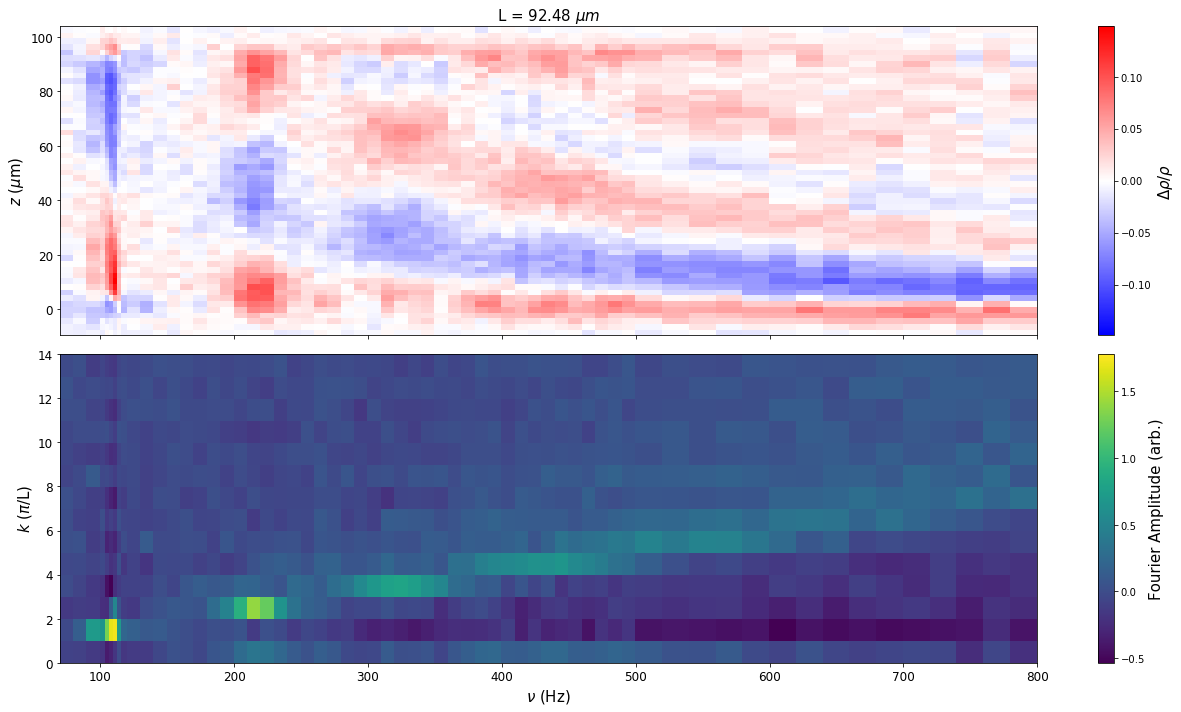

In [5688]:
# Plot 
fig, ax = plt.subplots(nrows=2, figsize=[18, 10], sharex=True)
plt.sca(ax[0])
plt.pcolor(*movie, cmap='bwr', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(L), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'$\Delta \rho / \rho$', fontsize=15)
plt.sca(ax[1])
plt.pcolor(*ft_real, cmap='viridis', linewidth=0, vmax=clim_ft)
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$k$ ($\pi$/L)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label='Fourier Amplitude (arb.)', fontsize=15)
fig.tight_layout()
if savefig.value: fig.savefig(suffix + 'DensityAndFT_IntegersOnly_RealPart_v2.pdf')

## Lorentzian Fits 

In [5707]:
# Lorentzian Fit Info 
mode_num = np.array([1, 2,3, 4, 5,])
ref_freq_guess = 110
gamma_guess = mode_num * 10

fit_lims = {'1' : [0, 140], '2':[120, 270], '3':[200, 400], '4':[170, 500], '5':[200,800], '6' : [300, 650], '7':[300,800]}
fit_lims = {}

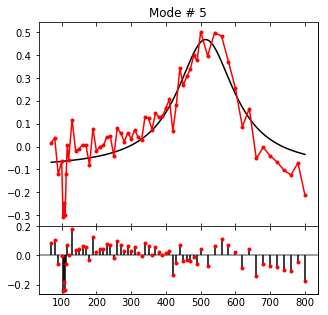

In [5708]:
# Lorentzian Fits 
mode_fits = []
ft = ft_real 

for i,m in enumerate(mode_num):
    ki = np.argmin(np.abs(ft[1] - m))
    guess = dict(x0 = ref_freq_guess*m, gamma = gamma_guess[i], amp=1, offset=0)
    c = tp.Curve(ft[0], ft[2][m,:]).trim(xlim=fit_lims.get(str(mode_num[i]), [-np.inf, np.inf]))
    cf = tp.curve_fit(tp.lorentzian, guess, *c.data, plot=False, info=False)
    mode_fits.append(cf)

# Slider plot 
def temp(test = 0):
    ax = mode_fits[test].plot(fiterrors=False)
    ax[0].set_title('Mode # {}'.format(mode_num[test]))
    plt.sca(ax[0])
    if savefig.value: plt.savefig(suffix + 'SampleFits_Mode{}.pdf'.format(mode_num[test]))
    plt.show()
if len(mode_num) == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, len(mode_num)-1))

In [5709]:
# Extract Data 
modes = pd.DataFrame()
modes['mode #'] = mode_num
modes['k (1/m)'] = mode_num * kscale * 1e6
modes['f (Hz)'] = [cf['x0'] for cf in mode_fits]
modes['f (Hz) error'] = [cf.fe['x0'] for cf in mode_fits]
modes['f0 (Hz)'] = modes['f (Hz)'] / modes['mode #']
modes['f0 (Hz) error'] = modes['f (Hz) error'] / modes['mode #']
modes['w (1/s)'] = modes['f (Hz)'] * twopi
modes['w (1/s) error'] = modes['f (Hz) error'] * twopi
modes['FWHM (Hz)'] = [cf['gamma'] for cf in mode_fits]
modes['FWHM (Hz) error'] = [cf.fe['gamma'] for cf in mode_fits]
modes['gamma (1/s)'] = modes['FWHM (Hz)'] * twopi
modes['gamma (1/s) error'] = modes['FWHM (Hz) error'] * twopi
modes['FT amplitude (arb.)'] = [cf['amp'] for cf in mode_fits]
modes['Q'] = modes['f (Hz)'] / modes['FWHM (Hz)']
modes['Q error'] = np.sqrt((modes['f (Hz) error'] / modes['FWHM (Hz)'])**2 + (modes['FWHM (Hz) error'] * modes['f (Hz)'] / modes['FWHM (Hz)']**2)**2)

modes

,mode #,k (1/m),f (Hz),f (Hz) error,f0 (Hz),f0 (Hz) error,w (1/s),w (1/s) error,FWHM (Hz),FWHM (Hz) error,gamma (1/s),gamma (1/s) error,FT amplitude (arb.),Q,Q error
0,1,33970.264624,106.892990,0.620510,106.892990,0.620510,671.628462,3.898782,15.377055,2.086866,96.616887,13.112163,1.910081,6.951460,0.944266
1,2,67940.529248,212.355509,1.292665,106.177755,0.646332,1334.269016,8.122052,42.139531,4.065916,264.770480,25.546907,1.539433,5.039342,0.487198
2,3,101910.793871,314.570062,2.987553,104.856687,0.995851,1976.501991,18.771350,105.776968,11.197972,664.616293,70.358935,0.957564,2.973899,0.316093
3,4,135881.058495,420.376775,3.702419,105.094194,0.925605,2641.305176,23.262985,143.678529,15.273753,902.758823,95.967820,0.772235,2.925815,0.312095
4,5,169851.323119,514.338077,6.826244,102.867615,1.365249,3231.681447,42.890558,200.916585,29.038559,1262.396138,182.454647,0.563656,2.559958,0.371549


In [5710]:
# Save Data 
if savefig.value: modes.to_excel(suffix + 'FTLorentzianFits_Data.xlsx')

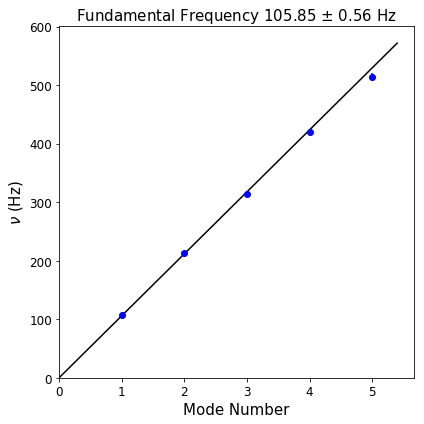

In [5711]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['mode #'], modes['f (Hz)'], modes['f (Hz) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['mode #'], modes['f (Hz)'], modes['f (Hz) error'], info=False, plot=False)
xp = np.linspace(0, modes['mode #'].max() + 0.4)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('Mode Number', fontsize=15)
plt.ylabel(r'$\nu$ (Hz)', fontsize=15)
plt.title(r'Fundamental Frequency {:.2f} $\pm$ {:.2f} Hz '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'FundamentalFrequency_v1.pdf')

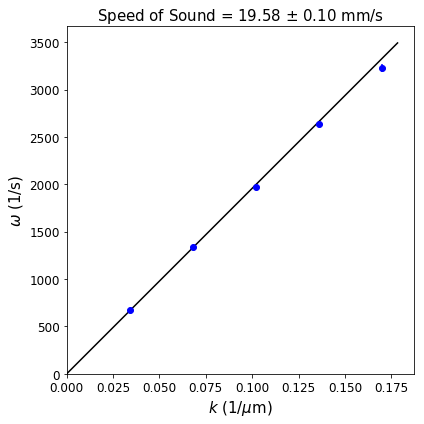

In [5712]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], info=False, plot=False)
dict_data['speed fit'] = cf
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/s)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0]*1e-3, cf.fe[0]*1e-3), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'Dispersion Relation_v1.pdf')

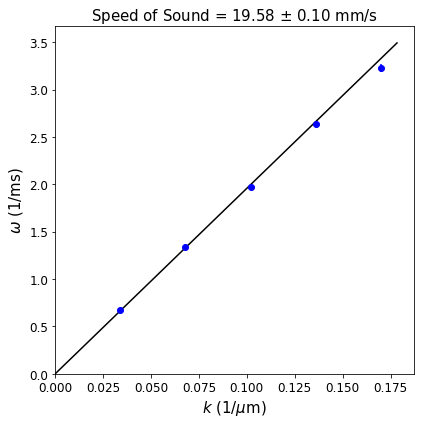

In [5713]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, info=False, plot=False)
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/ms)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'Dispersion Relation_v2.pdf')

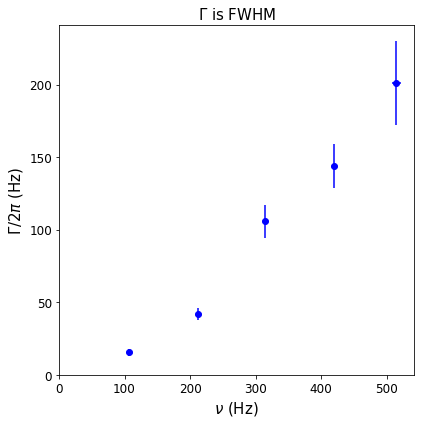

In [5714]:
# Plot Gamma vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['FWHM (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['FWHM (Hz) error'], fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'GammaVsOmega_v1.pdf')

     FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
a1   0.366295  0.054389  None      1        -inf         inf  14.848280
a0 -25.433778  8.383192  None      0        -inf         inf  32.960862


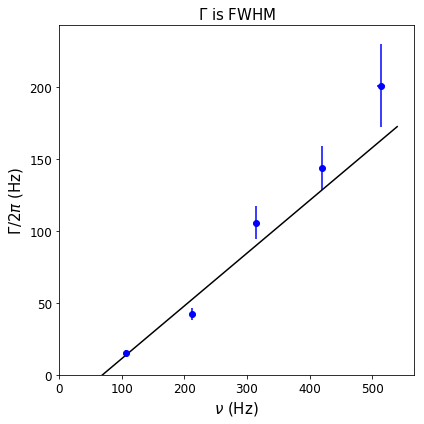

In [5715]:
# Plot Gamma vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['FWHM (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['FWHM (Hz) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=0, a0=0: a1*x + a0, [1, 0], modes['f (Hz)'], modes['FWHM (Hz)'], modes['FWHM (Hz) error'], info=True)
xp = np.linspace(0, cf.x.max()*1.05, 100)
plt.plot(xp, cf(xp), 'k-')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'GammaVsOmega_v2.pdf')

    FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
a2  0.000146  0.000012  None      1        -inf         inf   8.491679


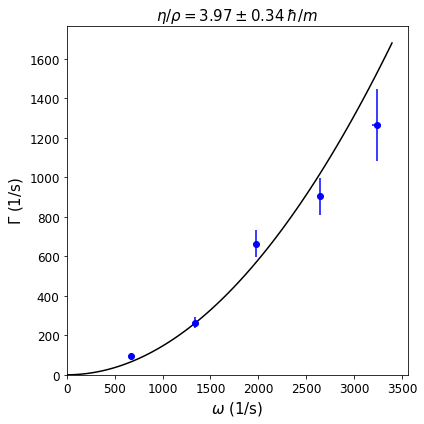

In [5716]:
# Plot Gamma vs Omega 
cf = tp.curve_fit(lambda x, a2=0: a2*x**2, [1], modes['w (1/s)'], modes['gamma (1/s)'], modes['gamma (1/s) error'], info=True)
speed = dict_data['speed fit'][0] * 1e-6
eta_rho = [3/4 * cf[0] * speed**2 * cst.mass / cst.hbar, 3/4 * cf.fe[0] * speed**2 * cst.mass / cst.hbar]
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['w (1/s)'], modes['gamma (1/s)'], xerr=modes['w (1/s) error'], yerr=modes['gamma (1/s) error'], fmt='bo')
xp = np.linspace(0, cf.x.max()*1.05, 100)
plt.plot(xp, cf(xp), 'k-')
plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
plt.ylabel(r'$\Gamma$ (1/s)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\eta / \rho = {:.2f} \pm {:.2f} \: \hbar / m$'.format(*eta_rho), fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'GammaVsOmega_v3.pdf')

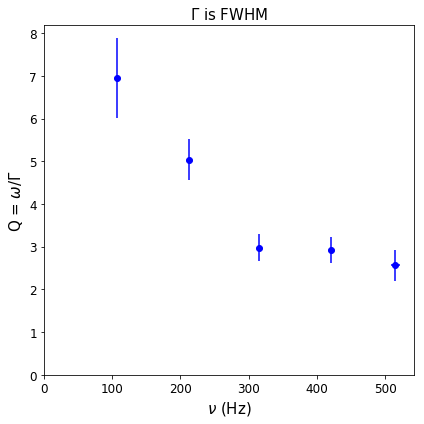

In [5717]:
# Plot Q vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['f (Hz)']/modes['FWHM (Hz)'], xerr=modes['f (Hz) error'], 
             yerr=np.sqrt((modes['f (Hz) error']/modes['FWHM (Hz)'])**2 + (modes['FWHM (Hz) error'] * modes['f (Hz)']/modes['FWHM (Hz)']**2)**2), fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'Q = $\omega / \Gamma $', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'QVsFreq_v1.pdf')

## Peaks in k

In [2761]:
modes

,mode #,k (1/m),f (Hz),f (Hz) error,f0 (Hz),f0 (Hz) error,w (1/s),w (1/s) error,FWHM (Hz),FWHM (Hz) error,gamma (1/s),gamma (1/s) error,FT amplitude (arb.),Q,Q error
0,1,35029.973020,80.220044,1.004653,80.220044,1.004653,504.037400,6.312422,8.669794,1.900431,54.473925,11.940758,0.945564,9.252820,2.031538
1,2,70059.946039,153.936408,0.877707,76.968204,0.438854,967.210978,5.514799,14.209010,2.558785,89.277841,16.077322,0.952610,10.833718,1.951934
2,3,105089.919059,233.484365,1.888932,77.828122,0.629644,1467.025529,11.868509,26.381245,5.971793,165.758252,37.521884,1.165496,8.850392,2.004699
3,4,140119.892079,308.244495,2.524744,77.061124,0.631186,1936.757284,15.863432,39.452672,7.713170,247.888447,48.463273,0.915559,7.813020,1.528819
4,5,175149.865098,388.016186,2.479347,77.603237,0.495869,2437.977597,15.578197,53.374154,7.816643,335.359703,49.113418,0.739382,7.269739,1.065666
5,6,210179.838118,464.050344,2.960682,77.341724,0.493447,2915.714304,18.602516,59.798007,9.433782,375.721962,59.274202,0.599904,7.760298,1.225272
6,7,245209.811137,533.581508,4.476861,76.225930,0.639552,3352.591489,28.128944,72.599843,14.555785,456.158267,91.456695,0.465986,7.349623,1.474840


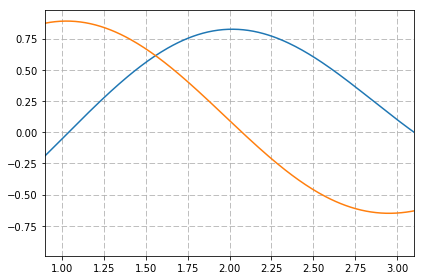

In [2771]:
mode = 2
use = 'Delta rho'
f_res = modes.loc[modes['mode #'] == mode, 'f (Hz)'].values[0]
f_index = np.argmin(np.abs(df_data.index.values - f_res))

L = df_data.iloc[f_index].length*1e6
z_buffer = 15
z_lim_ft = [z_buffer, L - z_buffer]
k_scale = np.pi / L
k = np.linspace(0, 10*k_scale, 1000)
x, y = df_data.iloc[f_index][use].trim(xlim = np.array(z_lim_ft)*1e-6).data
x = x*1e6 + 0
y /= df_data.iloc[f_index].amp
fk = tp.fourier_transform(x, y, k)[1]
plt.plot(k / k_scale, np.real(fk))
plt.plot(k / k_scale, np.imag(fk))
plt.grid(linestyle='--')
xlim_range = 1.1
plt.xlim([mode - xlim_range, mode + xlim_range])
plt.tight_layout()

## Waterfall Plot for FT

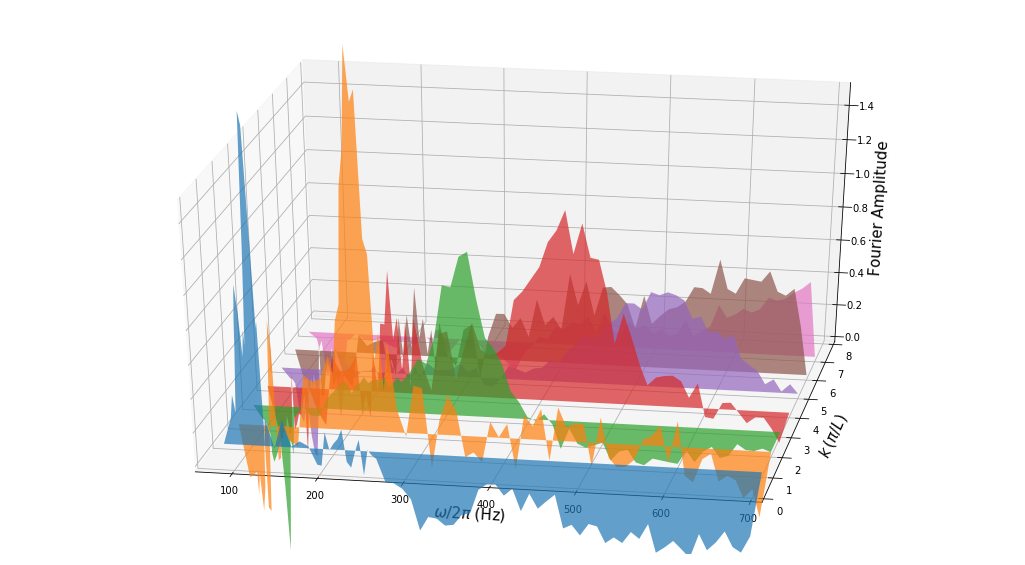

In [3338]:
# Waterfall Plot 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors


fig = plt.figure(figsize=[18,10])
ax = fig.gca(projection='3d')


def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.5)

xs = ft[0]
verts = []
zs = np.arange(1, 8, 1)
cs = [cc('C{}'.format(i % 10)) for i in range(len(zs))]
for z in zs:
    ys = ft[2][z,:]
    ys[0], ys[-1] = 0, 0
    verts.append(list(zip(xs, ys)))

poly = PolyCollection(verts,facecolors=cs)
poly.set_alpha(0.7)
ax.add_collection3d(poly, zs=zs, zdir='y')
ax.view_init(30, -90+10)
ax.set_xlabel(r'$\omega / 2 \pi$ (Hz)', fontsize=15)
ax.set_xlim3d(70, 700)
ax.set_ylabel(r'$k \: (\pi / L)$', fontsize=15)
ax.set_ylim3d(0, 8)
ax.set_zlabel('Fourier Amplitude', fontsize=15)
ax.set_zlim3d(0, 1.5)

if savefig.value: plt.savefig(suffix + 'Waterfall_FTModes_v1.pdf')

## 2D Profiles 

In [ ]:
# Colormap 
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
        'RWY', [(1,0,0),(1,1,1),(0.9,0.9,0)], N=1000)

In [ ]:
# 2D Profile 
mode_num = 2
shift = -1

freq_fit = float(modes[modes['mode #'] == mode_num]['f (Hz)'])
freq_data = movie[0][np.argmin(np.abs(movie[0] - freq_fit)) + shift]
z = df_data.loc[freq_data, '2D Delta rho']

roi = tp.get_roi(z, width=90, height=80)

fig, ax = plt.subplots(figsize=[6,5])
clim = np.max(np.abs(z[roi])) * 1.1
plt.imshow(-z[roi], origin=0, cmap=cmap, aspect='auto', clim=[-clim, clim])
ax.set_axis_off()
plt.tight_layout()
plt.savefig(suffix + 'SpainCMAP_v3.pdf')

## Misc

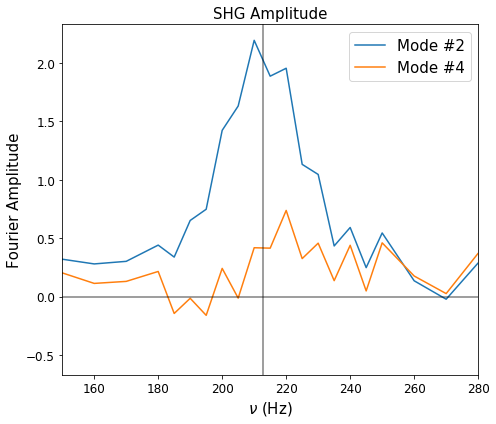

In [3342]:
# Plot SHG peaks 
mode_num = [2, 4]

plt.figure(figsize=[7,6])
for m in mode_num:
    plt.plot(ft[0], ft[2][m,:], label='Mode #{}'.format(m))
plt.axvline(modes[modes['mode #'] == mode_num[0]]['f (Hz)'].values[0], c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.legend(fontsize=15)
plt.xlim([150, 280])
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'Fourier Amplitude', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'SHG Amplitude', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'SHG_Amplitude_mode2.pdf')

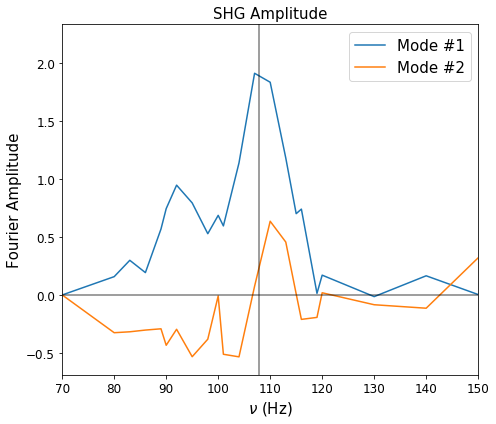

In [3343]:
# Plot SHG peaks 
mode_num = [1,2]

plt.figure(figsize=[7,6])
for m in mode_num:
    plt.plot(ft[0], ft[2][m,:], label='Mode #{}'.format(m))
plt.axvline(modes[modes['mode #'] == mode_num[0]]['f (Hz)'].values[0], c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.legend(fontsize=15)
plt.xlim([70, 150])
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'Fourier Amplitude', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'SHG Amplitude', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'SHG_Amplitude_mode1.pdf')

# Time Evolution

In [33]:
# Saving Figures 
savefig = ipywidgets.Checkbox(value=False, description='Save Fig')
display(savefig)
folder_name = df.iloc[0].name[0:14] + 'TimeEvolution'
suffix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
suffix

'08-26-2017_17_TimeEvolution/'

## 2D Plots

In [34]:
# Compute movies 
z_lims = np.array([-10, 105]) * 1e-6
use = 'Delta rho'
movie = np.array([nz.trim(xlim=z_lims).y for nz in df_data[use]]).T / np.mean(df_data.amp)
movie = [df_data.index.values, df_data[use].iloc[0].trim(xlim=z_lims).x*1e6, movie]

In [133]:
# Compute FT 
L = np.mean(df_data.length) * 1e6
kscale = np.pi/L
FT_z_lims = [0, L]
z_ind = (movie[1] >= FT_z_lims[0]) & (movie[1] <= FT_z_lims[1])
k = np.arange(0, 15 * kscale, 1 * kscale)
ft = np.array([tp.fourier_transform(movie[1][z_ind], movie[2][z_ind, i], k)[1] for i in range(movie[0].size)]).T
ft_real = [movie[0], k/kscale, np.real(ft)]
ft_imag = [movie[0], k/kscale, np.imag(ft)]
ft_abs = [movie[0], k/kscale, np.abs(ft)]

In [134]:
# Plot Prep 
clim_movie = np.max(np.abs(movie[2])) * 0.8
clim_ft = np.max(np.abs(ft_abs[2])) * 0.8
ft = ft_real

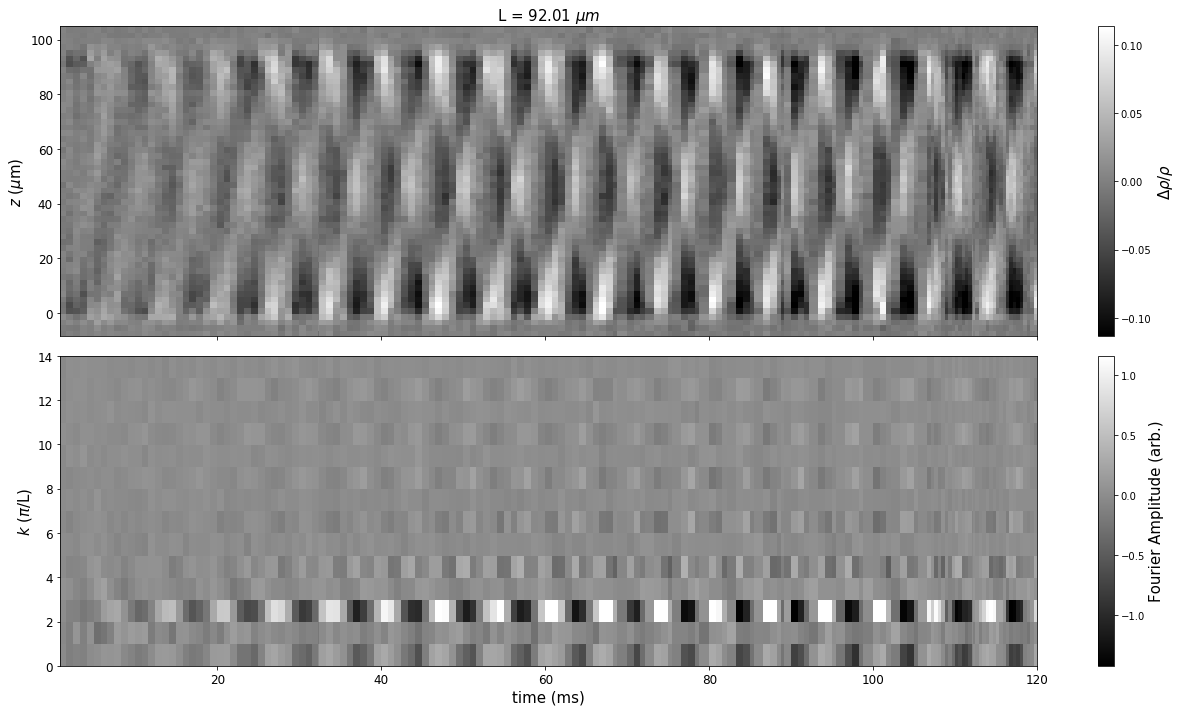

In [135]:
# Plot 
fig, ax = plt.subplots(nrows=2, figsize=[18, 10], sharex=True)
plt.sca(ax[0])
plt.pcolor(*movie, cmap='gray', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(L), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'$\Delta \rho / \rho$', fontsize=15)
plt.sca(ax[1])
plt.pcolor(*ft, cmap='gray', linewidth=0, vmax=clim_ft)
plt.xlabel(r'time (ms)', fontsize=15)
plt.ylabel(r'$k$ ($\pi$/L)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label='Fourier Amplitude (arb.)', fontsize=15)
fig.tight_layout()
if savefig.value: fig.savefig(suffix + 'DensityAndFT_IntegersOnly_RealPart_v1.pdf')

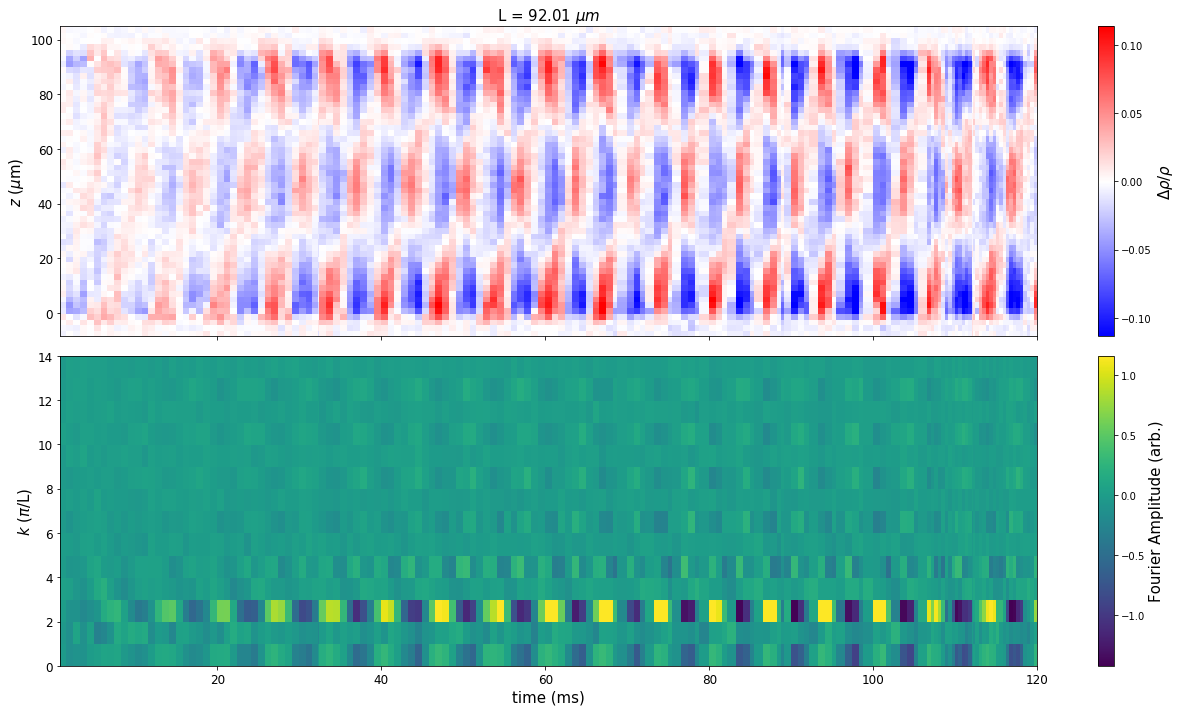

In [136]:
# Plot 
fig, ax = plt.subplots(nrows=2, figsize=[18, 10], sharex=True)
plt.sca(ax[0])
plt.pcolor(*movie, cmap='bwr', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(L), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'$\Delta \rho / \rho$', fontsize=15)
plt.sca(ax[1])
plt.pcolor(*ft, cmap='viridis', linewidth=0, vmax=clim_ft)
plt.xlabel(r'time (ms)', fontsize=15)
plt.ylabel(r'$k$ ($\pi$/L)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label='Fourier Amplitude (arb.)', fontsize=15)
fig.tight_layout()
if savefig.value: fig.savefig(suffix + 'DensityAndFT_IntegersOnly_RealPart_v2.pdf')

## Animation 

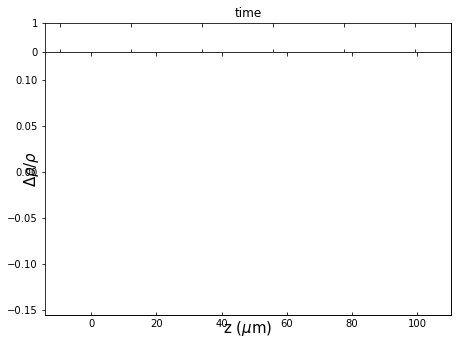

In [195]:
# 1D Profile Animation 

fig, ax = plt.subplots(figsize=[7, 5])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'z ($\mu$m)', fontsize=15)
plt.ylabel(r'$\Delta \rho / \rho$', fontsize=15)
plt.ylim([-0.12, 0.12])
plt.tight_layout()
(ax2, ax) = tp.divide_axes(ax, shared=False, divider=0.9)
ax2.set_title('time')
artists = []
upto = min(130, len(movie[0]))

for i in range(upto):
    p1 = ax.plot(movie[1], movie[2][:,i], 'k-')[0]
    p2 = ax2.axvline(movie[0][i], c='k', linewidth=5)
    artists.append([p1,p2])

ani = animation.ArtistAnimation(fig, artists, interval=150, repeat_delay=2000, repeat=True, )
if savefig.value: ani.save(suffix + 'SecondMode1DProfileVStime_v1.gif',  writer='imagemagick')
HTML(ani.to_html5_video()) 

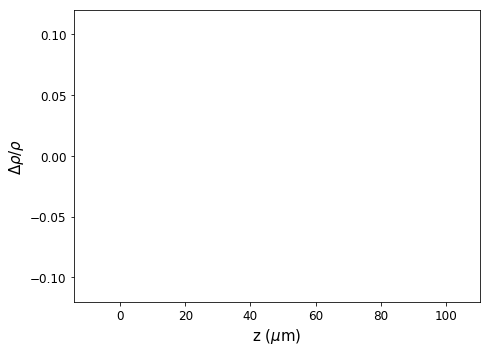

In [196]:
# 1D Profile Animation 

fig, ax = plt.subplots(figsize=[7, 5])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([-0.12, 0.12])
plt.xlabel(r'z ($\mu$m)', fontsize=15)
plt.ylabel(r'$\Delta \rho / \rho$', fontsize=15)
plt.tight_layout()
artists = []
upto = min(130, len(movie[0]))

for i in range(upto):
    p1 = ax.plot(movie[1], movie[2][:,i], 'k-')[0]
    artists.append([p1])

ani = animation.ArtistAnimation(fig, artists, interval=150, repeat_delay=2000, repeat=True, )
if savefig.value: ani.save(suffix + 'SecondMode1DProfileVStime_v2.gif',  writer='imagemagick')
HTML(ani.to_html5_video()) 

In [217]:
# 2D profile settings 
roi = tp.get_roi(df_data.iloc[0]['2D Delta rho'], width=80, height=80)
clim = [-5,5]

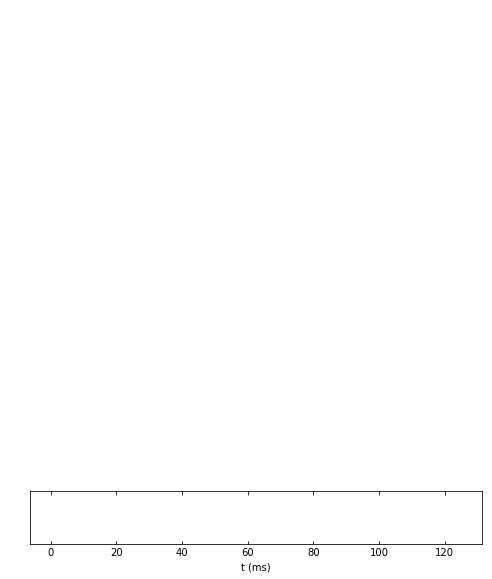

In [218]:
# 2D Profile Animation 

# Create list of artists for animation 
fig, ax = plt.subplots(figsize=[7, 8])
plt.tight_layout()
ax1, ax2 = tp.divide_axes(ax, divider=0.1, shared=False)
ax.set_axis_off()
ax1.set_axis_off()
ax2.get_yaxis().set_visible(False)
ax2.set_xlabel('t (ms)')
artists = []

for x in range(upto):
    p1 = ax.imshow(df_data.iloc[x]['2D Delta rho'][roi], origin=0, cmap='gray', clim=clim)
    p2 = ax2.axvline(x, c='k', linewidth=5)
    artists.append([p1,p2])

ani = animation.ArtistAnimation(fig, artists, interval=200, repeat_delay=2000, repeat=True, )
if savefig.value: ani.save(suffix + 'SecondMode2DProfileVStime_v1.gif',  writer='imagemagick')
# HTML(ani.to_html5_video()) 
# plt.show()

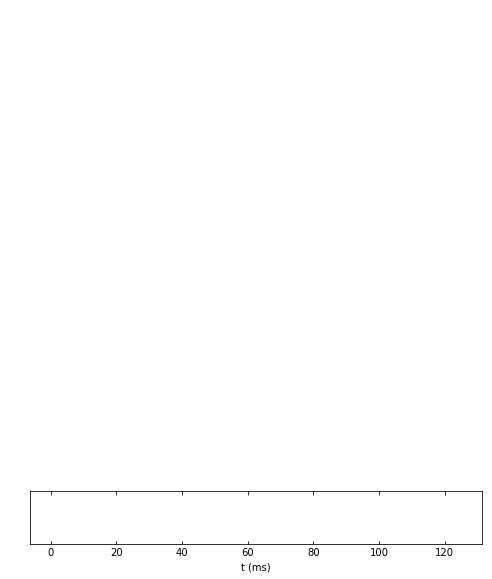

In [219]:
# 2D Profile Animation 
# Create list of artists for animation 
fig, ax = plt.subplots(figsize=[7, 8])
plt.tight_layout()
ax1, ax2 = tp.divide_axes(ax, divider=0.1, shared=False)
ax.set_axis_off()
ax1.set_axis_off()
ax2.get_yaxis().set_visible(False)
ax2.set_xlabel('t (ms)')
artists = []

for x in range(upto):
    p1 = ax.imshow(df_data.iloc[x]['2D Delta rho'][roi], origin=0, cmap='bwr', clim=clim)
    p2 = ax2.axvline(x, c='k', linewidth=5)
    artists.append([p1,p2])

ani = animation.ArtistAnimation(fig, artists, interval=200, repeat_delay=2000, repeat=True, )
if savefig.value: ani.save(suffix + 'SecondMode2DProfileVStime_v2.gif',  writer='imagemagick')
# HTML(ani.to_html5_video()) 
# plt.show()

## Cuts 

           FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
tau       23.674005  2.359378    ms  20.00        -inf         inf   9.966111
freq       0.149560  0.000086   kHz   0.15        -inf         inf   0.057321
phase     -1.428587  0.046556  None   0.00        -inf         inf   3.258868
amp        1.264564  0.031097  None   1.50        -inf         inf   2.459125
offset     0.000000  0.000000   NaN   0.00    0.000000    0.000000   0.000000
gradient   0.000000  0.000000   NaN   0.00    0.000000    0.000000   0.000000


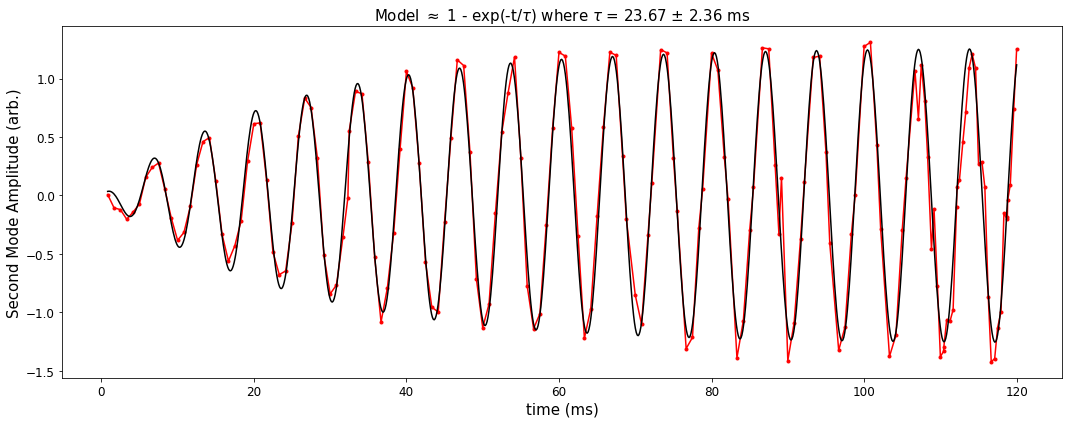

In [144]:
# Growth of Fourier Amplitude vs time 
mode = 2 
k_ind = np.argmin(np.abs(ft[1] - mode))

# Fit function
def saturated_growth(t, tau=1, freq=1, phase=0, amp=1, offset=0, gradient=0):
    return amp * (1-np.exp(-t/tau)) * np.sin(twopi*freq*t - phase) + offset + gradient * t

# Data and Fit
c2 = tp.Curve(ft[0], ft[2][k_ind, :])
guess = dict(tau=[20, 'ms'], freq=[df_data.freq.iloc[0]/1e3, 'kHz'], phase = 0, amp = 1.5,)
fixed = dict(freq = df_data.freq.iloc[0]/1e3)
cf2 = tp.curve_fit(saturated_growth, guess, *c2.data, plot=False, info=True, fixed=fixed)

# Plot 
fig, ax = plt.subplots(figsize=[15,6])
plt.plot(*c2.data, 'r.-')
plt.plot(cf2.xp, cf2(cf2.xp), 'k')
plt.xlabel(r'time (ms)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Second Mode Amplitude (arb.)', fontsize=15)
plt.title(r'Model $\approx$ 1 - exp(-t/$\tau$) where $\tau$ = {:.2f} $\pm$ {:.2f} ms'.format(cf2['tau'], cf2.fe['tau']), fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'SecondModeGrowth_v1.pdf')

           FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
tau       23.674005  2.359378    ms  20.00        -inf         inf   9.966111
freq       0.149560  0.000086   kHz   0.15        -inf         inf   0.057321
phase     -1.428587  0.046556  None   0.00        -inf         inf   3.258868
amp        1.264564  0.031097  None   1.50        -inf         inf   2.459125
offset     0.000000  0.000000   NaN   0.00    0.000000    0.000000   0.000000
gradient   0.000000  0.000000   NaN   0.00    0.000000    0.000000   0.000000
           FitValue   FitError Units  Guess  LowerBound  UpperBound   FitError%
tau       31.689285  10.345818    ms   20.0        -inf         inf   32.647685
freq       0.298918   0.000294   kHz    0.3        -inf         inf    0.098287
phase      0.515871   0.162595  None    0.0        -inf         inf   31.518421
amp       -0.277400   0.027605  None    0.5        -inf         inf    9.951388
offset     0.011449   0.017935  None    0.0        -in

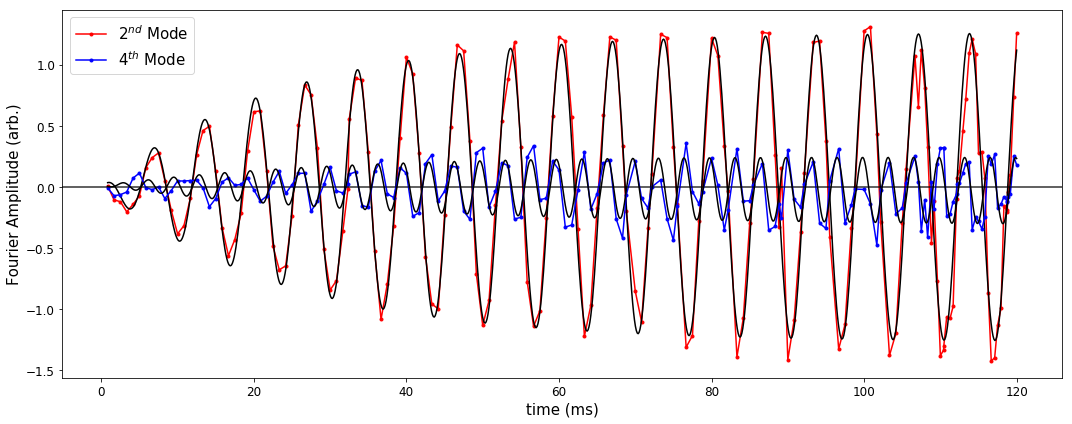

In [163]:
# Growth of Fourier Amplitude vs time 
mode = 2 
k_ind = np.argmin(np.abs(ft[1] - mode))

# Fit function
def saturated_growth(t, tau=1, freq=1, phase=0, amp=1, offset=0, gradient=0):
    return amp * (1-np.exp(-t/tau)) * np.sin(twopi*freq*t - phase) + offset + gradient * t

# Data and Fit
c2 = tp.Curve(ft[0], ft[2][k_ind, :])
guess = dict(tau=[20, 'ms'], freq=[df_data.freq.iloc[0]/1e3, 'kHz'], phase = 0, amp = 1.5,)
fixed = dict(freq = df_data.freq.iloc[0]/1e3)
cf2 = tp.curve_fit(saturated_growth, guess, *c2.data, plot=False, info=True, fixed=fixed)

# 4th mode, SHG
mode = 4
k_ind = np.argmin(np.abs(ft[1] - mode))
c4 = tp.Curve(ft[0], ft[2][k_ind, :])
guess = dict(tau=[20, 'ms'], freq=[df_data.freq.iloc[0]/1e3 * 2, 'kHz'], phase = 0, amp = 0.5, offset=0, gradient=0)
fixed = dict(freq = df_data.freq.iloc[0]/1e3)
cf4 = tp.curve_fit(saturated_growth, guess, *c4.data, plot=False, info=True, fixed=fixed)
if cf4['amp'] < 0:
    cf4.fr.loc['amp','FitValue'] = -1 * cf4['amp']
    cf4.fr.loc['phase','FitValue'] = cf4['phase'] + np.pi
plot_offset = 0

# Compute Various things 
phase_diff = [(cf4['phase'] - cf2['phase']) * 180 / np.pi, np.sqrt((cf4.fe['phase'])**2 +(cf2.fe['phase'])**2) * 180 / np.pi]

# Plot 
fig, ax = plt.subplots(figsize=[15,6])
plt.plot(*c2.data, 'r.-', label=r'2$^{nd}$ Mode')
plt.plot(cf2.xp, cf2(cf2.xp), 'k')
plt.axhline(0, c='k', alpha=0.5)
plt.plot(c4.x, c4.y + plot_offset, 'b.-', label=r'4$^{th}$ Mode')
plt.plot(cf4.xp, cf4(cf4.xp) + plot_offset, 'k')
plt.axhline(plot_offset, c='k', alpha=0.5)
plt.xlabel(r'time (ms)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.ylabel('Fourier Amplitude (arb.)', fontsize=15)
# plt.title(r'$\tau_2$ = {:.2f} $\pm$ {:.2f} ms; $\tau_4$ = {:.2f} $\pm$ {:.2f} ms'.format(cf2['tau'], 
#                                                     cf2.fe['tau'], cf4['tau'], cf4.fe['tau']), fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'SecondModeGrowth_SHG_v1.pdf')

           FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
tau       23.674005  2.359378    ms  20.00        -inf         inf   9.966111
freq       0.149560  0.000086   kHz   0.15        -inf         inf   0.057321
phase     -1.428587  0.046556  None   0.00        -inf         inf   3.258868
amp        1.264564  0.031097  None   1.50        -inf         inf   2.459125
offset     0.000000  0.000000   NaN   0.00    0.000000    0.000000   0.000000
gradient   0.000000  0.000000   NaN   0.00    0.000000    0.000000   0.000000
           FitValue   FitError Units  Guess  LowerBound  UpperBound   FitError%
tau       31.689285  10.345818    ms   20.0        -inf         inf   32.647685
freq       0.298918   0.000294   kHz    0.3        -inf         inf    0.098287
phase      0.515871   0.162595  None    0.0        -inf         inf   31.518421
amp       -0.277400   0.027605  None    0.5        -inf         inf    9.951388
offset     0.011449   0.017935  None    0.0        -in

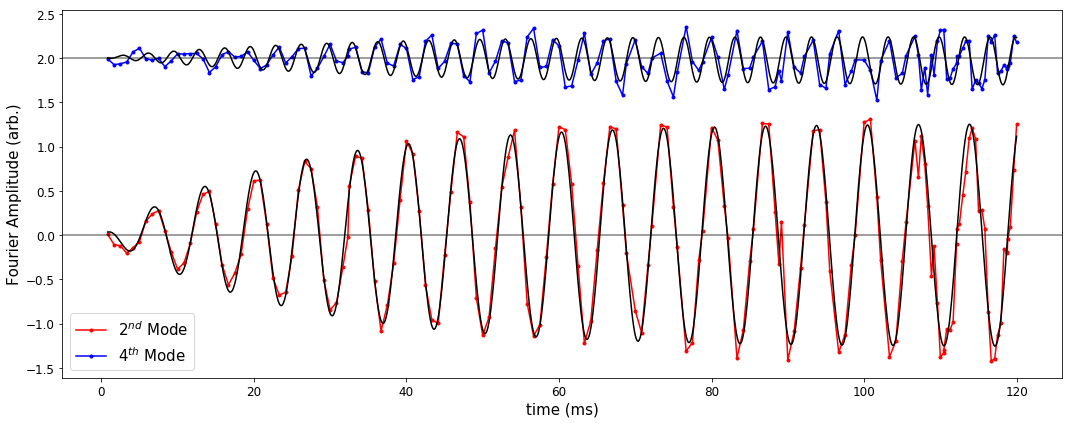

In [164]:
# Growth of Fourier Amplitude vs time 
mode = 2 
k_ind = np.argmin(np.abs(ft[1] - mode))

# Fit function
def saturated_growth(t, tau=1, freq=1, phase=0, amp=1, offset=0, gradient=0):
    return amp * (1-np.exp(-t/tau)) * np.sin(twopi*freq*t - phase) + offset + gradient * t

# Data and Fit
c2 = tp.Curve(ft[0], ft[2][k_ind, :])
guess = dict(tau=[20, 'ms'], freq=[df_data.freq.iloc[0]/1e3, 'kHz'], phase = 0, amp = 1.5,)
fixed = dict(freq = df_data.freq.iloc[0]/1e3)
cf2 = tp.curve_fit(saturated_growth, guess, *c2.data, plot=False, info=True, fixed=fixed)

# 4th mode, SHG
mode = 4
k_ind = np.argmin(np.abs(ft[1] - mode))
c4 = tp.Curve(ft[0], ft[2][k_ind, :])
guess = dict(tau=[20, 'ms'], freq=[df_data.freq.iloc[0]/1e3 * 2, 'kHz'], phase = 0, amp = 0.5, offset=0, gradient=0)
fixed = dict(freq = df_data.freq.iloc[0]/1e3)
cf4 = tp.curve_fit(saturated_growth, guess, *c4.data, plot=False, info=True, fixed=fixed)
if cf4['amp'] < 0:
    cf4.fr.loc['amp','FitValue'] = -1 * cf4['amp']
    cf4.fr.loc['phase','FitValue'] = cf4['phase'] + np.pi
plot_offset = 2

# Compute Various things 
phase_diff = [(cf4['phase'] - cf2['phase']) * 180 / np.pi, np.sqrt((cf4.fe['phase'])**2 +(cf2.fe['phase'])**2) * 180 / np.pi]

# Plot 
fig, ax = plt.subplots(figsize=[15,6])
plt.plot(*c2.data, 'r.-', label=r'2$^{nd}$ Mode')
plt.plot(cf2.xp, cf2(cf2.xp), 'k')
plt.axhline(0, c='k', alpha=0.5)
plt.plot(c4.x, c4.y + plot_offset, 'b.-', label=r'4$^{th}$ Mode')
plt.plot(cf4.xp, cf4(cf4.xp) + plot_offset, 'k')
plt.axhline(plot_offset, c='k', alpha=0.5)
plt.xlabel(r'time (ms)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.ylabel('Fourier Amplitude (arb.)', fontsize=15)
# plt.title(r'$\tau_2$ = {:.2f} $\pm$ {:.2f} ms; $\tau_4$ = {:.2f} $\pm$ {:.2f} ms'.format(cf2['tau'], 
#                                                     cf2.fe['tau'], cf4['tau'], cf4.fe['tau']), fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'SecondModeGrowth_SHG_v2.pdf')

           FitValue    FitError Units  Guess  LowerBound  UpperBound    FitError%
tau       18.191335  126.031797    ms   20.0        -inf         inf   692.812256
freq       0.601714    0.001659   kHz    0.6        -inf         inf     0.275694
phase      0.019466    1.043193  None    0.0        -inf         inf  5358.932085
amp       -0.052469    0.019279  None    0.5        -inf         inf    36.743889
offset     0.003742    0.015269  None    0.0        -inf         inf   408.056974
gradient   0.000108    0.000202  None    0.0        -inf         inf   187.325563


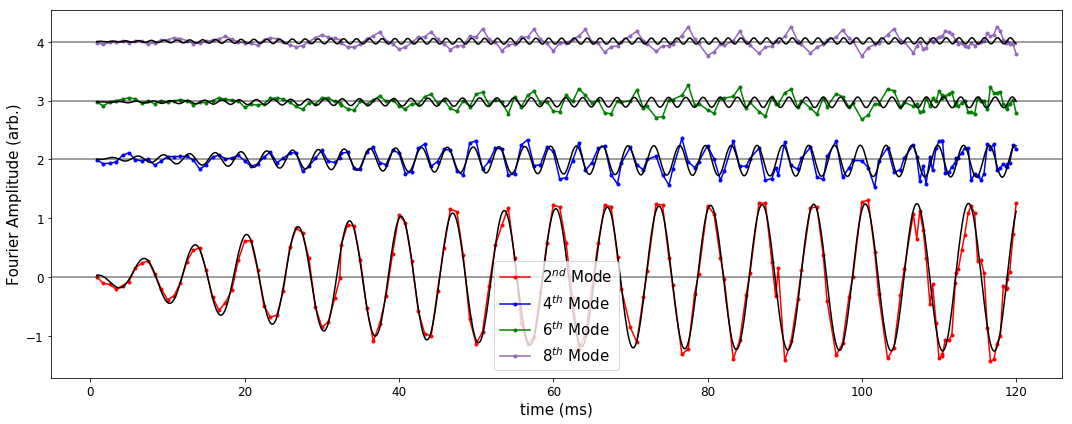

In [172]:
# Growth of Fourier Amplitude vs time 
mode = 2 
k_ind = np.argmin(np.abs(ft[1] - mode))

# Fit function
def saturated_growth(t, tau=1, freq=1, phase=0, amp=1, offset=0, gradient=0):
    return amp * (1-np.exp(-t/tau)) * np.sin(twopi*freq*t - phase) + offset + gradient * t

# Data and Fit
c2 = tp.Curve(ft[0], ft[2][k_ind, :])
guess = dict(tau=[20, 'ms'], freq=[df_data.freq.iloc[0]/1e3, 'kHz'], phase = 0, amp = 1.5,)
fixed = dict(freq = df_data.freq.iloc[0]/1e3)
cf2 = tp.curve_fit(saturated_growth, guess, *c2.data, plot=False, info=False, fixed=fixed)

# 4th mode, SHG
mode = 4
k_ind = np.argmin(np.abs(ft[1] - mode))
c4 = tp.Curve(ft[0], ft[2][k_ind, :])
guess = dict(tau=[20, 'ms'], freq=[df_data.freq.iloc[0]/1e3 * 2, 'kHz'], phase = 0, amp = 0.5, offset=0, gradient=0)
fixed = dict(freq = df_data.freq.iloc[0]/1e3)
cf4 = tp.curve_fit(saturated_growth, guess, *c4.data, plot=False, info=False, fixed=fixed)
if cf4['amp'] < 0:
    cf4.fr.loc['amp','FitValue'] = -1 * cf4['amp']
    cf4.fr.loc['phase','FitValue'] = cf4['phase'] + np.pi
plot_offset_4 = 2

# 6th mode, SHG
mode = 6
k_ind = np.argmin(np.abs(ft[1] - mode))
c6 = tp.Curve(ft[0], ft[2][k_ind, :])
guess = dict(tau=[20, 'ms'], freq=[df_data.freq.iloc[0]/1e3 * 3, 'kHz'], phase = 0, amp = 0.5, offset=0, gradient=0)
fixed = dict()
cf6 = tp.curve_fit(saturated_growth, guess, *c6.data, plot=False, info=False, fixed=fixed)
if cf6['amp'] < 0:
    cf6.fr.loc['amp','FitValue'] = -1 * cf6['amp']
    cf6.fr.loc['phase','FitValue'] = cf6['phase'] + np.pi
plot_offset_6 = 3

# 8th mode, SHG
mode = 8
k_ind = np.argmin(np.abs(ft[1] - mode))
c8 = tp.Curve(ft[0], ft[2][k_ind, :])
guess = dict(tau=[20, 'ms'], freq=[df_data.freq.iloc[0]/1e3 * 4, 'kHz'], phase = 0, amp = 0.5, offset=0, gradient=0)
fixed = dict()
cf8 = tp.curve_fit(saturated_growth, guess, *c8.data, plot=False, info=True, fixed=fixed)
plot_offset_8 = 4

# Compute Various things 
phase_diff = [(cf4['phase'] - cf2['phase']) * 180 / np.pi, np.sqrt((cf4.fe['phase'])**2 +(cf2.fe['phase'])**2) * 180 / np.pi]

# Plot 
fig, ax = plt.subplots(figsize=[15,6])
plt.plot(*c2.data, 'r.-', label=r'2$^{nd}$ Mode')
plt.plot(cf2.xp, cf2(cf2.xp), 'k')
plt.axhline(0, c='k', alpha=0.5)
plt.plot(c4.x, c4.y + plot_offset_4, 'b.-', label=r'4$^{th}$ Mode')
plt.plot(cf4.xp, cf4(cf4.xp) + plot_offset_4, 'k')
plt.axhline(plot_offset_4, c='k', alpha=0.5)
plt.plot(c6.x, c6.y + plot_offset_6, 'g.-', label=r'6$^{th}$ Mode')
plt.plot(cf6.xp, cf6(cf6.xp) + plot_offset_6, 'k')
plt.axhline(plot_offset_6, c='k', alpha=0.5)
plt.plot(c8.x, c8.y + plot_offset_8, 'C4.-', label=r'8$^{th}$ Mode')
plt.plot(cf8.xp, cf8(cf8.xp) + plot_offset_8, 'k')
plt.axhline(plot_offset_8, c='k', alpha=0.5)
plt.xlabel(r'time (ms)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.ylabel('Fourier Amplitude (arb.)', fontsize=15)
# plt.title(r'$\tau_2$ = {:.2f} $\pm$ {:.2f} ms; $\tau_4$ = {:.2f} $\pm$ {:.2f} ms'.format(cf2['tau'], 
#                                                     cf2.fe['tau'], cf4['tau'], cf4.fe['tau']), fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'SecondModeGrowth_SHG_v3.pdf')

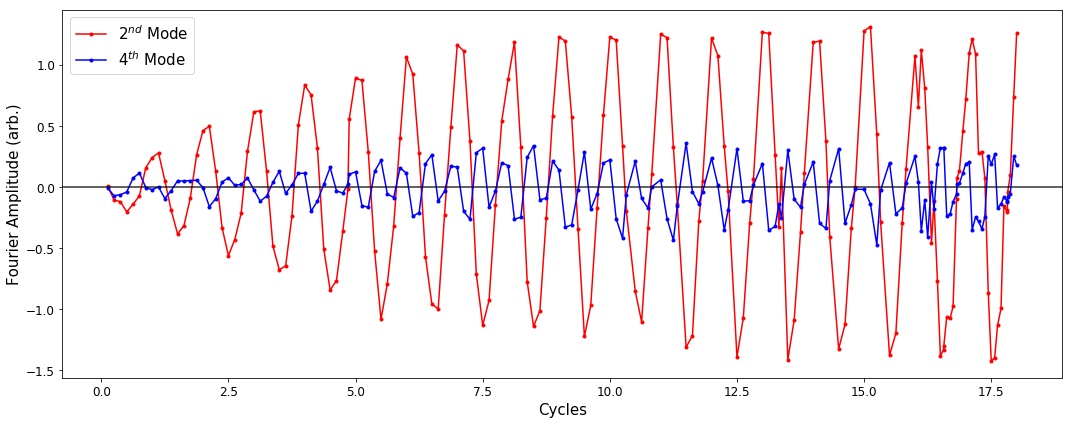

In [250]:
# Growth of Fourier Amplitude vs Cycles
mode = 2 
k_ind = np.argmin(np.abs(ft[1] - mode))
c2 = tp.Curve(df_data.cycles.values, ft[2][k_ind, :])
mode = 4
k_ind = np.argmin(np.abs(ft[1] - mode))
c4 = tp.Curve(df_data.cycles.values, ft[2][k_ind, :])
plot_offset = 0
# Plot 
fig, ax = plt.subplots(figsize=[15,6])
plt.plot(*c2.data, 'r.-', label=r'2$^{nd}$ Mode')
plt.axhline(0, c='k', alpha=0.5)
plt.plot(c4.x, c4.y + plot_offset, 'b.-', label=r'4$^{th}$ Mode')
plt.axhline(plot_offset, c='k', alpha=0.5)
plt.xlabel(r'Cycles', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.ylabel('Fourier Amplitude (arb.)', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'SecondModeGrowth_SHG_Cycles_v1.pdf')

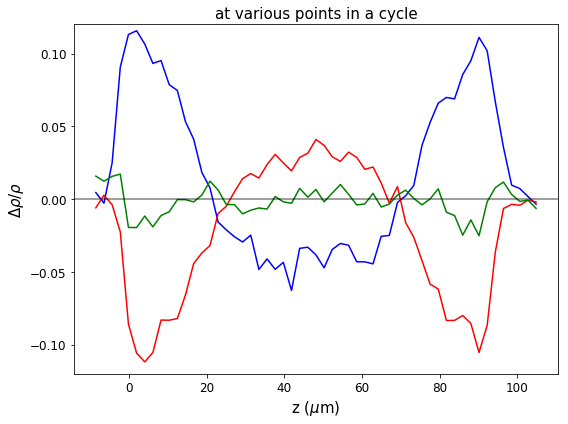

In [257]:
# Density Profile at Maximas 
cycles = df_data.cycles.values 
at = [10, 10.625, 16.8175]
at = [np.argwhere(cycles == a)[0,0] for a in at]

fig, ax = plt.subplots(figsize=[8,6])
plt.plot(movie[1], movie[2][:,at[0]], 'b', label='N Cycles')
plt.plot(movie[1], movie[2][:,at[1]], 'r', label='N + 1/2 Cycles')
plt.plot(movie[1], movie[2][:,at[2]], 'g', label='N + 1/4 Cycles')
plt.axhline(0, c='k', alpha=0.5)
# plt.legend(fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'z ($\mu$m)', fontsize=15)
plt.ylabel(r'$\Delta \rho / \rho$', fontsize=15)
plt.ylim([-0.12, 0.12])
plt.title('at various points in a cycle', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + '1DProfilesAtVariousPoints_v1.pdf')

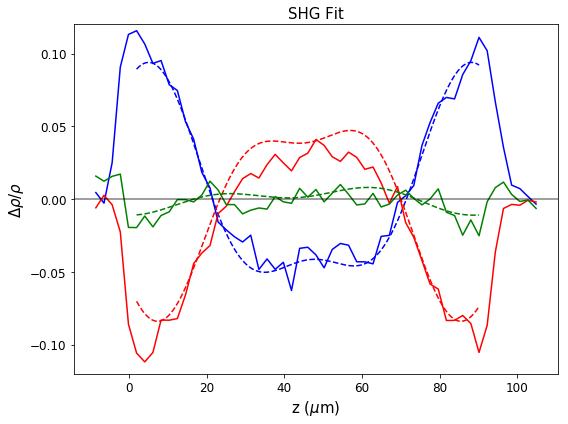

In [267]:
# Density Profile at Maximas 
cycles = df_data.cycles.values 
at = [10, 10.625, 16.8175]
at = [np.argwhere(cycles == a)[0,0] for a in at]

# Fitting function 
def fitfun_SHG(z, wl = L, amp1=0.1, phase1=0, amp2=0.02, phase2=0, offset=0, gradient=0):
    return amp1 * np.cos(twopi/wl*z + phase1) + amp2 * np.cos(2 * twopi/wl*z + phase2) + offset + gradient * z

cs = [tp.Curve(movie[1], movie[2][:,a]) for a in at]
cf = [tp.curve_fit(fitfun_SHG, [L, 0.1, 0, 0.02, 0, ], *c.trim(xlim=[0, L]).data) for c in cs]
fmt = ['b','r','g']

fig, ax = plt.subplots(figsize=[8,6])
for i in range(len(at)):
    plt.plot(*cs[i].data, '{}-'.format(fmt[i]))
    plt.plot(cf[i].xp, cf[i](cf[i].xp), '{}--'.format(fmt[i]))

plt.axhline(0, c='k', alpha=0.5)
# plt.legend(fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'z ($\mu$m)', fontsize=15)
plt.ylabel(r'$\Delta \rho / \rho$', fontsize=15)
plt.ylim([-0.12, 0.12])
plt.title('SHG Fit', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + '1DProfilesAtVariousPoints_v2.pdf')

# Theory

* kinematic viscosity $\eta$ for a unitary Fermi gas using dimentional analysis. Here $n$ is atomic number density 
$$ \eta = \hbar n \: f\left( \frac{T}{T_F} \right) $$

* More useful form using $\rho = m \: n$ the atomic mass density
$$ \frac{\eta}{\rho} = \frac{\hbar}{m}  \: f\left( \frac{T}{T_F} \right) $$

* Sound propagation differential equation
$$ find it and source it $$

* Relating decay of sound modes with viscosity, here $k = 2\pi / \lambda$ is the wave vector 
$$ \Gamma = \frac{4}{3} \frac{\eta}{\rho} k^2 = \frac{4}{3} \frac{\hbar}{m} k^2  \: f\left( \frac{T}{T_F} \right)   $$

* Interesting bit is the $f\left( \frac{T}{T_F} \right)$, the $\frac{\eta}{\rho}$ in units of $\frac{\hbar}{m}$
$$ \frac{\eta}{\rho} \frac{m}{\hbar}  =  f\left( \frac{T}{T_F} \right) =  \frac{3}{4} \frac{m }{\hbar} \frac{\Gamma}{k^2} $$

* For standing waves, $\lambda_n = 2 L / n$. So, $k_n =  n\pi / L $. Here n represents the $n^{th}$ mode and not atomic density
$$ f\left( \frac{T}{T_F} \right) =  \frac{3}{4} \frac{m }{\hbar} \frac{\Gamma \: L^2}{n^2 \pi^2} $$